https://www.analyticsvidhya.com/blog/2021/06/tuning-hyperparameters-of-an-artificial-neural-network-leveraging-keras-tuner/

https://towardsdatascience.com/hyperparameter-tuning-with-keras-tuner-283474fbfbe

In [1]:
#!pip install numpy==1.23.4
!pip install keras_tuner
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 3.1 MB/s eta 0:00:00


In [2]:
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import date

from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

import time
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import _tree
from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import scipy.stats as stats
import pylab

import shap
import re

from sklearn.feature_selection import mutual_info_regression

import lightgbm as lg
import xgboost as xg

In [218]:
import folium
from folium.plugins import MarkerCluster
from folium import plugins
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

In [5]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

from sklearn.metrics import confusion_matrix
import itertools

import keras_tuner as kt
from keras_tuner import RandomSearch, HyperModel, BayesianOptimization, Hyperband
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf


### Functions

In [ ]:
#################
### Pie chart ###
#################

def pie_chat(name):
    c_loc = df.sort_values(by = name)
    c_loc = c_loc.groupby([name]).size().to_frame('Count')
    c_loc = c_loc.reset_index()
    c_loc['perc'] = c_loc['Count']/df.shape[0] * 100
    c_loc = c_loc.sort_values(by = 'perc', ascending = False)
    c_loc['cum_perc'] = c_loc['perc'].cumsum()
    c_loc = c_loc.reset_index(drop=True)

    my_circle = plt.Circle( (0,0), 0.7, color='white')

    plt.pie(c_loc.perc, labels=c_loc[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

In [91]:
############################################
### Data sub populations from tree model ###
############################################

def get_rules(tree, feature_names, class_names, perc_thold = 80, sample_thold = 100):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    proba = []
    samples = []
    for path in paths:
        #print(path)
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"

        if (np.round(100.0*classes[l]/np.sum(classes),2) > perc_thold) & (path[-1][1] > sample_thold):
            rules += [rule]
            proba += [np.round(100.0*classes[l]/np.sum(classes),2)]            
        
    return rules, proba

In [3]:
#################################
### Variance inflation factor ###
#################################

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    return(vif)

In [4]:
##############################
### Min-Max transformation ###
##############################

def minmax_dset(dset,numeric_columns):

    dseta = dset.copy()
    dsetb = pd.DataFrame(transformer_train.transform(dseta[numeric_columns]))
    dsetb.columns = numeric_columns
    print(dsetb.shape)
    return dsetb

In [5]:
########################
### One hot encoding ###
########################

def ohe_dset(dset,categorical_columns):

    dseta = dset.copy()
    transformed_dset = ohe.fit_transform(dseta[categorical_columns])
    cat_data = pd.DataFrame(transformed_dset.toarray())
    cat_data.columns = ohe.get_feature_names_out(input_features=dseta[categorical_columns].columns)
    print(cat_data.shape)
    return cat_data

In [6]:
class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(
            Dense(
                units=hp.Int('units', 8, 64, 4, default=8),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                input_shape=input_shape
            )
        )

        model.add(
            Dense(
                units=hp.Int('units', 16, 64, 4, default=16),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
            )
        )

        model.add(
            Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.1,
                    default=0.005,
                    step=0.01)
            )
        )

        model.add(Dense(1))

        model.compile(
            optimizer='rmsprop',loss='mse',metrics=['mse']
        )

        return model

NameError: name 'HyperModel' is not defined

In [7]:
def diag_vals(model):

  y_pred = model.predict(X_test)

  mae = mean_absolute_error(y_test, y_pred)
  print("MAE: ", mae)

  rmse = mean_squared_error(y_test, y_pred, squared=False)
  print("RMSE: ", rmse)

  r2 = r2_score(y_test, y_pred)
  print("R2 score: ", r2)

  return mae, rmse, r2

In [ ]:
def resid_vals(pred):

    y_pred = pd.DataFrame(pred, columns = ['Pred'])

    residual = y_test - y_pred.Pred.values
    
    y_pred.index = range(0,len(y_pred))
    residual.index = range(0,len(residual))
    a = pd.concat([residual,y_pred],axis=1,ignore_index=True)
    resid_data = pd.DataFrame(a)
    resid_data.columns = ['Residuals','Predicted']
    plt.plot(resid_data['Residuals'], 'o', color='blue', markersize=3)
    plt.title('Residual plot for model')
    plt.ylabel('Residuals')
    plt.show();
    
    ax = sns.jointplot(x=resid_data['Predicted'], y=resid_data['Residuals'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
    ax.ax_joint.set_xlabel('Predicted', fontweight='bold')
    ax.ax_joint.set_ylabel('Residuals', fontweight='bold')
    plt.show();
    
    stats.probplot(resid_data['Residuals'], dist="norm", plot=pylab)
    pylab.show();

### Read in the data

In [10]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Change directory
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/New York City Airbnb Open Data")
# Print out the current directory
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/New York City Airbnb Open Data


In [119]:
df1 = pd.read_csv('Diamonds Prices2022.csv', sep = ',')
df1 = df1.drop_duplicates()
df1 = df1.drop(['Unnamed: 0'], axis = 1)
print(df1.shape)
df1.head()

(53943, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


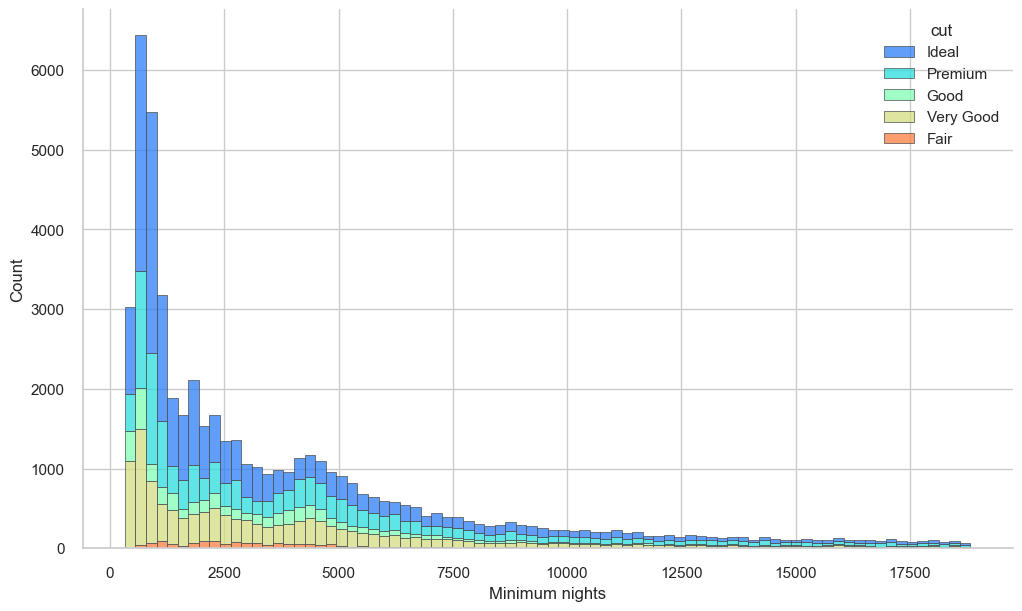

In [120]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    df1,
    x="price", hue="cut",
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Minimum nights")
plt.show();

### Adjust data

In [121]:
#pd.crosstab(df.time_since.isnull(), columns = 'Count')

In [122]:
#a = pd.crosstab(time_s, columns = 'Count')
#a = a.reset_index()
#a = a.sort_values(['Count'], ascending = False)
#a.head()
#a = pd.DataFrame(delat)
#a.median()[0]

In [226]:
df = df1.copy()
df = df[(df.x > 0) & (df.y > 0) & (df.z > 0) & (df.y < 30) & (df.z < 30)]
df['xy_ratio'] = df.x / df.y
df['xz_ratio'] = df.x / df.z
df['yz_ratio'] = df.y / df.z
df['size'] = df.x * df.y * df.z

In [227]:
#pd.crosstab(df.gender,columns = 'Count')
print(list(df.columns))

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'size']


In [228]:
for i in range(df.shape[1]):
    print(f"The number of unique classes for {df.columns[i]} is {df.iloc[:,i].nunique()}")
    if df.iloc[:,i].nunique() < 15:
        print(f"    The classes are {df.iloc[:,i].unique()}")

The number of unique classes for carat is 273
The number of unique classes for cut is 5
    The classes are ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
The number of unique classes for color is 7
    The classes are ['E' 'I' 'J' 'H' 'F' 'G' 'D']
The number of unique classes for clarity is 8
    The classes are ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']
The number of unique classes for depth is 184
The number of unique classes for table is 127
The number of unique classes for price is 11597
The number of unique classes for x is 553
The number of unique classes for y is 548
The number of unique classes for z is 372
The number of unique classes for xy_ratio is 7578
The number of unique classes for xz_ratio is 11701
The number of unique classes for yz_ratio is 11856
The number of unique classes for size is 28462


In [229]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,xy_ratio,xz_ratio,yz_ratio,size
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,0.992462,1.625514,1.637860,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,1.013021,1.683983,1.662338,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,0.995086,1.753247,1.761905,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,0.992908,1.596958,1.608365,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,0.997701,1.578182,1.581818,51.917250


### Missing data

In [129]:
a = pd.DataFrame(df.isna().mean().round(4) * 100, columns = ['Count'])
a

,Count
carat,0.0
cut,0.0
color,0.0
clarity,0.0
depth,0.0
table,0.0
price,0.0
x,0.0
y,0.0
z,0.0


### Target variable

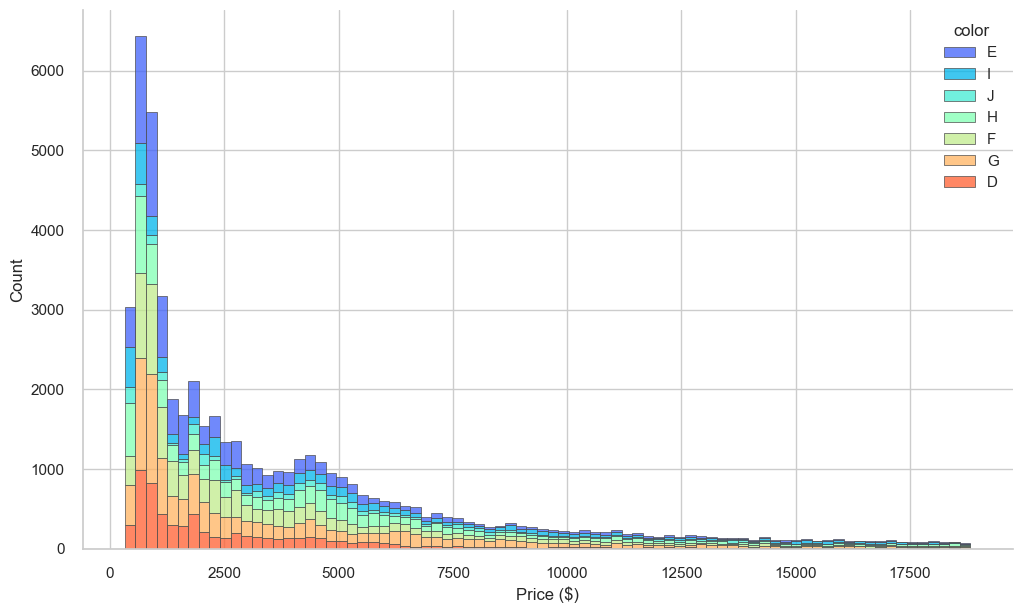

In [130]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    df,
    x="price", hue="color",
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Price ($)")
plt.show();

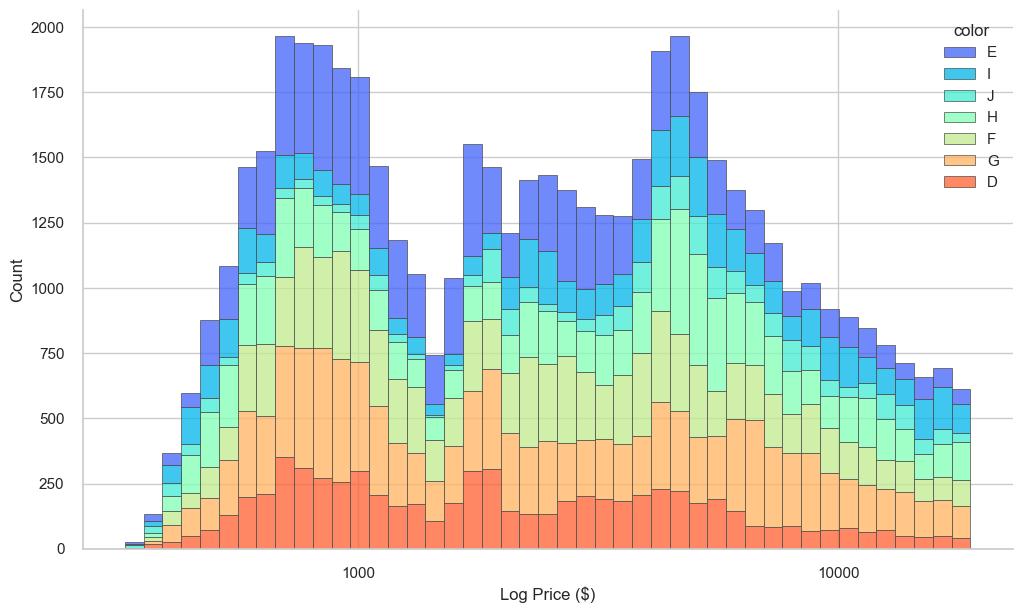

In [131]:
dfa = df.copy()
dfa.price = dfa.price + 1

f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    dfa,
    x="price", hue="color",
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Log Price ($)")
plt.show();

### Graphs

#### Pie charts

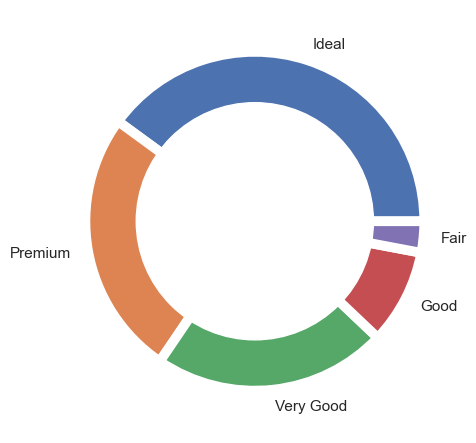

In [132]:
pie_chat('cut')    

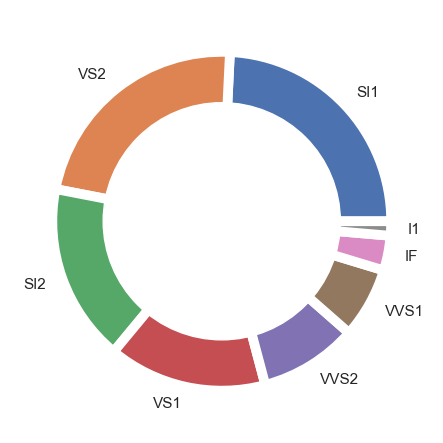

In [133]:
pie_chat('clarity')    

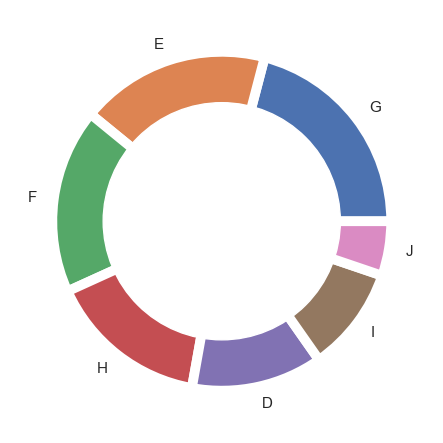

In [134]:
pie_chat('color')    

#### Scatter plots

In [230]:
print(list(df.columns))

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'size']


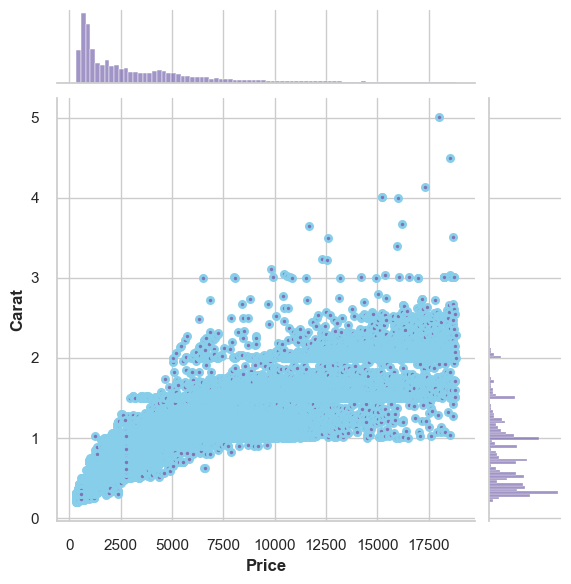

In [146]:
ax = sns.jointplot(x=df['price'], y=df['carat'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('Price', fontweight='bold')
ax.ax_joint.set_ylabel('Carat', fontweight='bold')
plt.show();

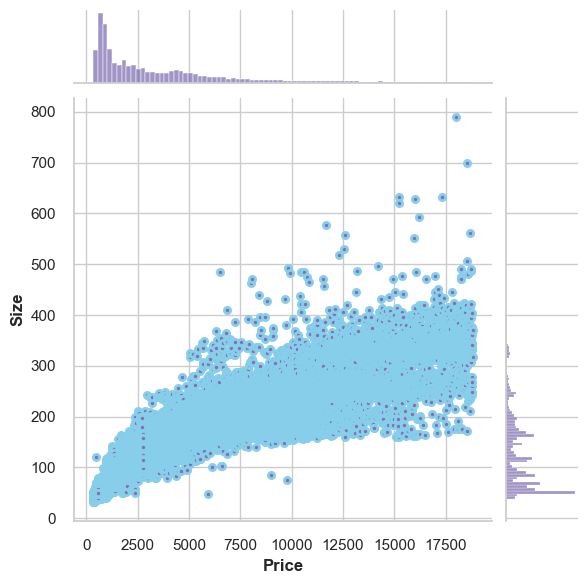

In [231]:
ax = sns.jointplot(x=df['price'], y=df['size'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('Price', fontweight='bold')
ax.ax_joint.set_ylabel('Size', fontweight='bold')
plt.show();

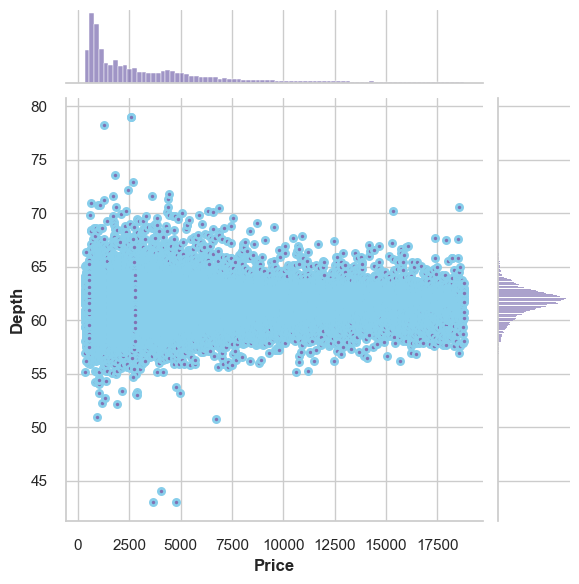

In [147]:
ax = sns.jointplot(x=df['price'], y=df['depth'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('Price', fontweight='bold')
ax.ax_joint.set_ylabel('Depth', fontweight='bold')
plt.show();

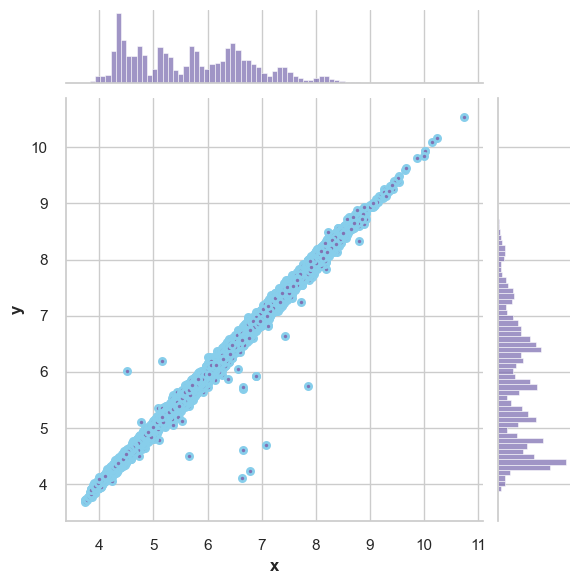

In [148]:
ax = sns.jointplot(x=df['x'], y=df['y'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('x', fontweight='bold')
ax.ax_joint.set_ylabel('y', fontweight='bold')
plt.show();

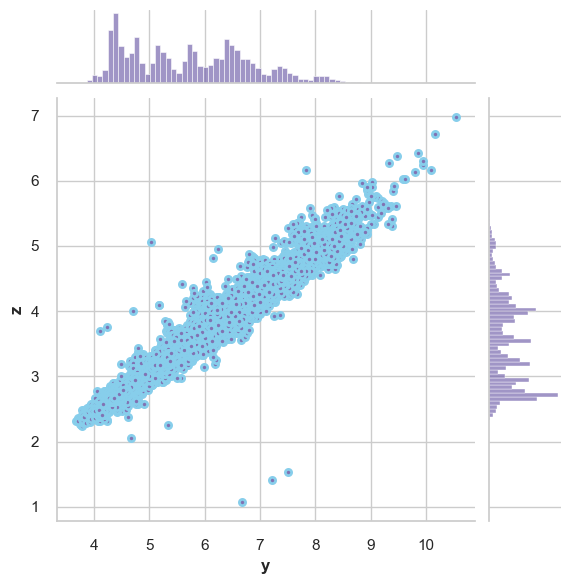

In [149]:
ax = sns.jointplot(x=df['y'], y=df['z'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('y', fontweight='bold')
ax.ax_joint.set_ylabel('z', fontweight='bold')
plt.show();

#### Box plots

In [31]:
print(list(df.columns))

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']


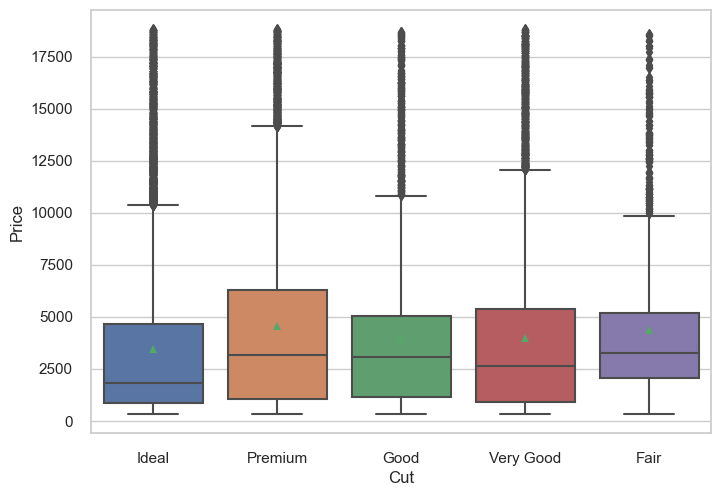

In [151]:
sns.boxplot(data=df, x="cut", y="price", showmeans = True)
plt.xlabel("Cut")
plt.xticks(rotation=0)
plt.ylabel("Price")
plt.show()

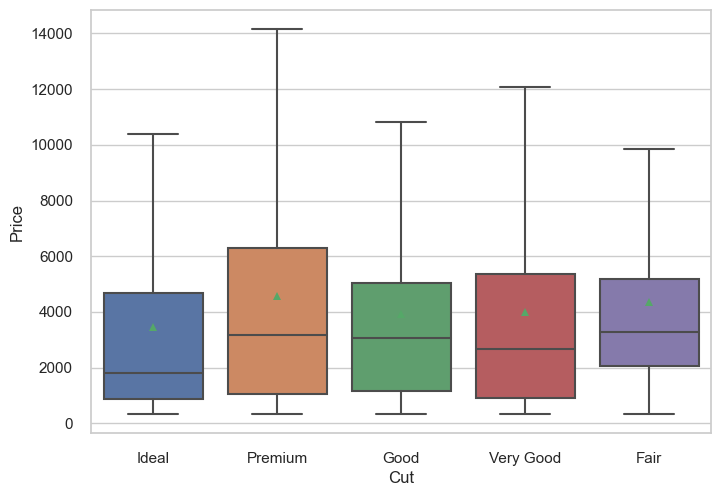

In [152]:
sns.boxplot(data=df, x="cut", y="price", showfliers = False, showmeans = True)
plt.xlabel("Cut")
plt.xticks(rotation=0)
plt.ylabel("Price")
plt.show()

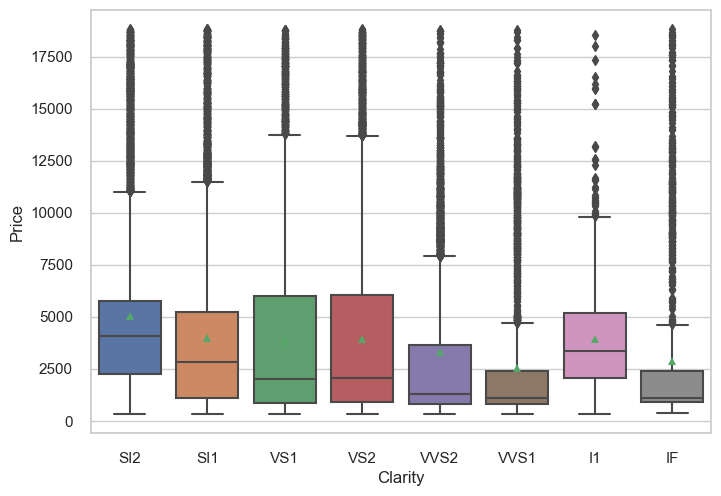

In [153]:
sns.boxplot(data=df, x="clarity", y="price", showfliers = True, showmeans = True)
plt.xlabel("Clarity")
plt.xticks(rotation=0)
plt.ylabel("Price")
plt.show()

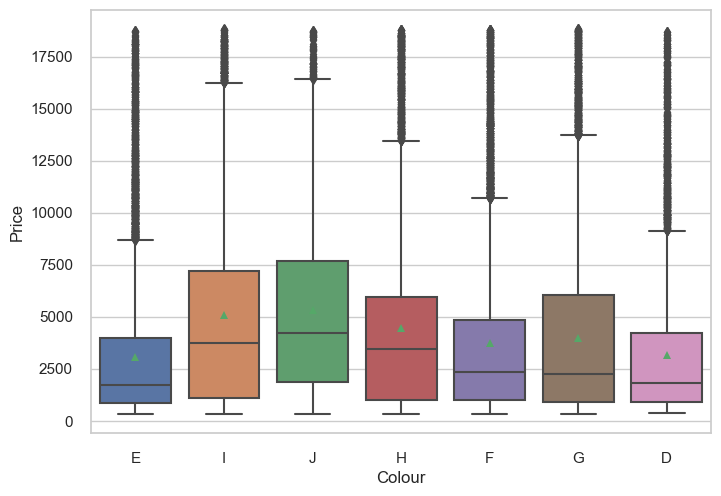

In [154]:
sns.boxplot(data=df, x="color", y="price", showmeans = True)
plt.xlabel("Colour")
plt.xticks(rotation=0)
plt.ylabel("Price")
plt.show()

#### Rel plots

In [ ]:
# room_type_Entire_homeapt            0.290289
# room_type_Private_room              0.249939
# calculated_host_listings_count      0.157652
# neighbourhood_group_Manhattan       0.074881
# minimum_nights                      0.049430
# availability_365                    0.035308
# neighbourhood_group_Brooklyn        0.028105
# time_since                          0.028033

In [40]:
print(list(df.columns))

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']


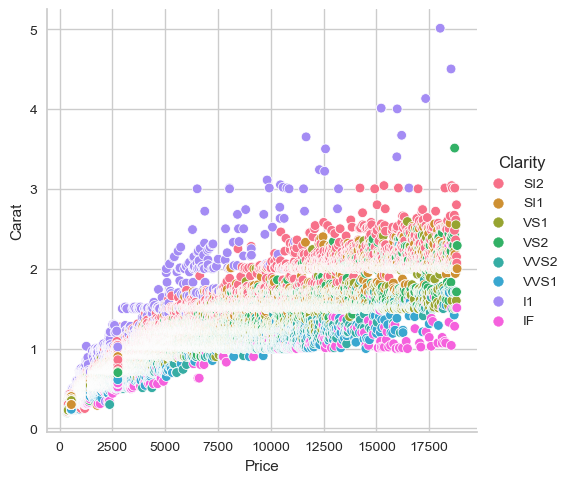

In [49]:
relplot = sns.relplot(x='price',
            y='carat',
            data=df,
            kind='scatter',
            hue='clarity');
relplot.set_ylabels("Carat", clear_inner=False)
relplot.set_xlabels("Price", clear_inner=False)
relplot._legend.set_title("Clarity")
plt.show();

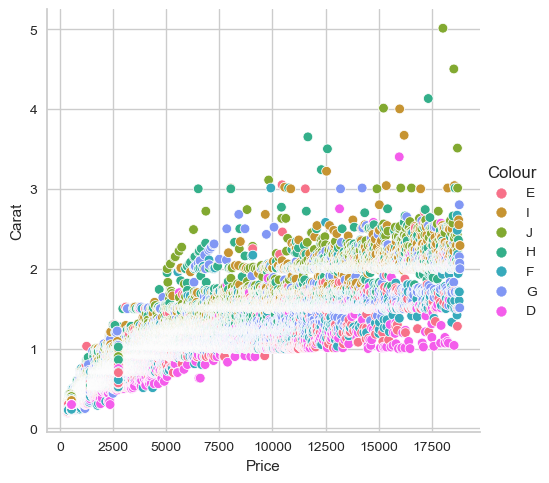

In [50]:
relplot = sns.relplot(x='price',
            y='carat',
            data=df,
            kind='scatter',
            hue='color');
relplot.set_ylabels("Carat", clear_inner=False)
relplot.set_xlabels("Price", clear_inner=False)
relplot._legend.set_title("Colour")
plt.show();

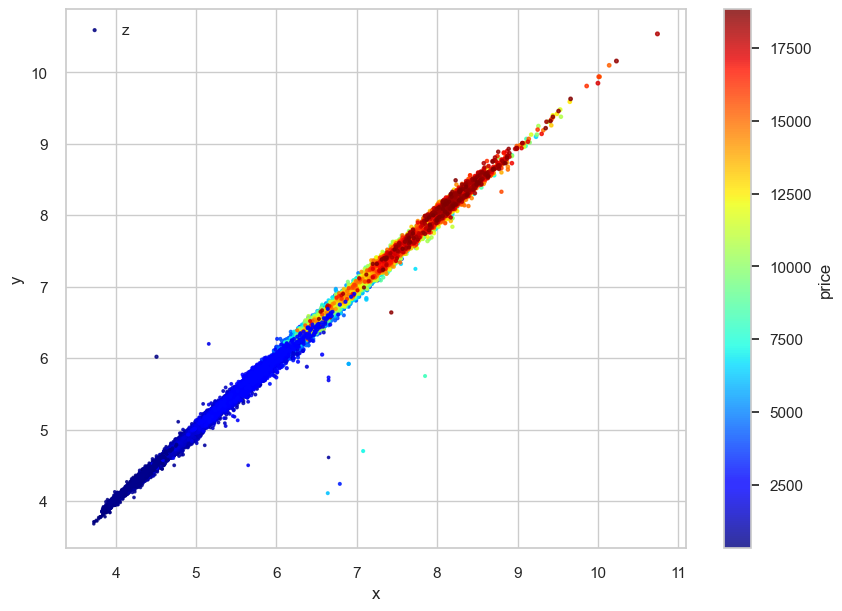

In [155]:
dfa = df[(df.y < 30) & (df.x > 3) & (df.y > 3)]
dfa.plot(kind="scatter", x="x", y="y", alpha=0.8,
             s=dfa["z"], label="z", figsize=(10,7),
             c="price", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show()

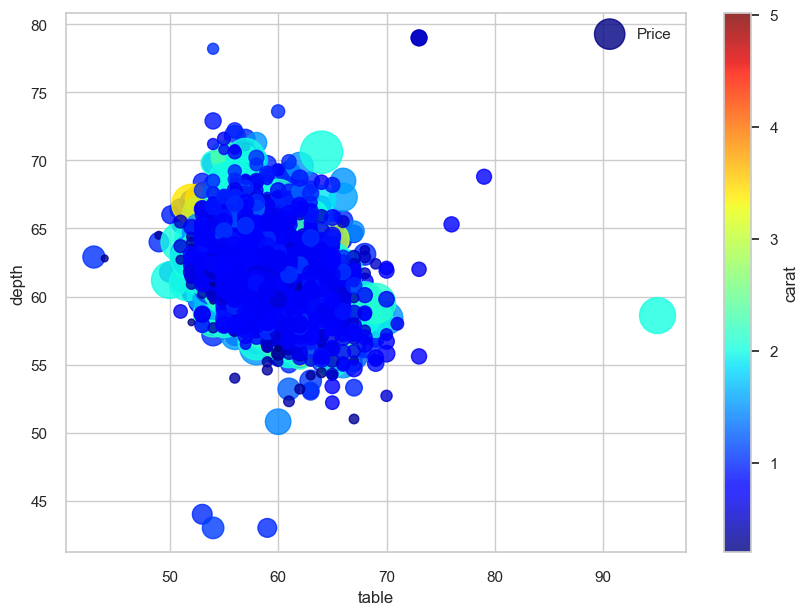

In [156]:
dfa = df.copy()
dfa.price = dfa.price / 20
dfa.plot(kind="scatter", x="table", y="depth", alpha=0.8,
             s=dfa["price"], label="Price", figsize=(10,7),
             c="carat", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show();

#### Heat maps

In [61]:
print(list(df.columns))

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']


In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


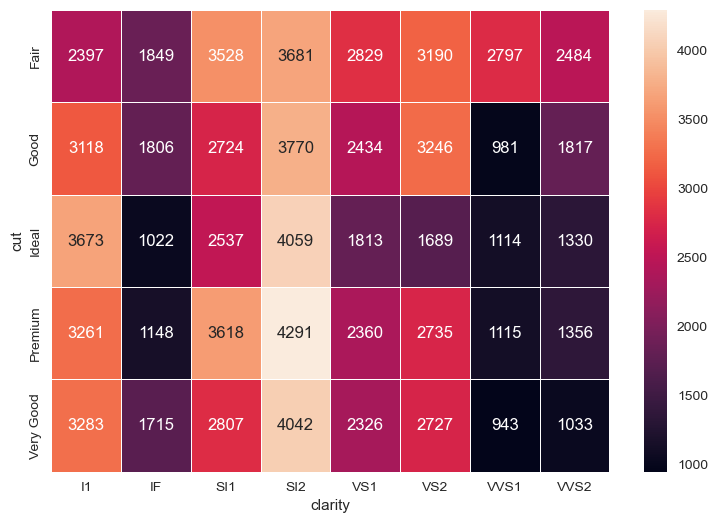

In [62]:
data_a = df.groupby(['cut','clarity'])['price'].median()
data_a = data_a.reset_index()
data_a = data_a.pivot("cut","clarity", "price")
data_a.head()

for i in range(data_a.shape[1]):
    data_a.iloc[:,i] = data_a.iloc[:,i].fillna(0)
    data_a.iloc[:,i] = data_a.iloc[:,i].astype(int)

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_a, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.show();

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


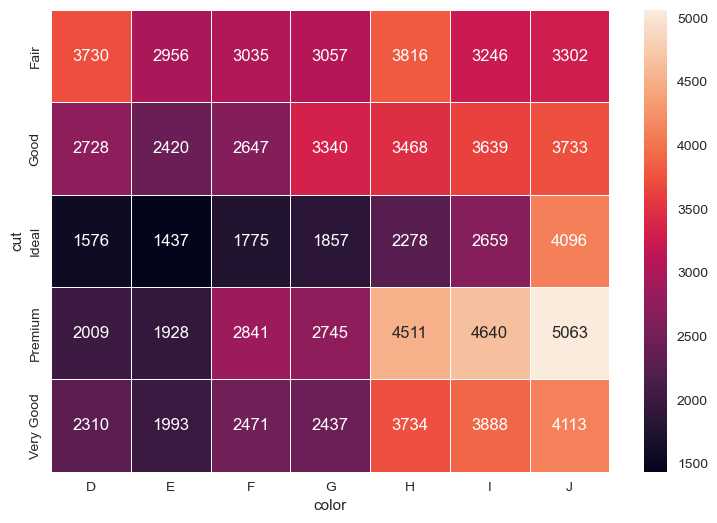

In [63]:
data_a = df.groupby(['cut','color'])['price'].median()
data_a = data_a.reset_index()
data_a = data_a.pivot("cut","color", "price")
data_a.head()

for i in range(data_a.shape[1]):
    data_a.iloc[:,i] = data_a.iloc[:,i].fillna(0)
    data_a.iloc[:,i] = data_a.iloc[:,i].astype(int)

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_a, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.show();

#### Compare plot

In [68]:
data_b = df.groupby(['clarity','color'])['price'].median()
data_b = data_b.reset_index()
data_c = data_b
data_c = data_c.pivot('clarity','color', "price")
data_c = data_c.reset_index()
data_c = data_c.sort_values("clarity", ascending=True)

for name in ['D','E','F','G','H','I','J']:
    data_c.loc[:,name] = data_c.loc[:,name].fillna(0)
    data_c.loc[:,name] = data_c.loc[:,name].astype(int)
data_c.head()

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


color,clarity,D,E,F,G,H,I,J
0,I1,3774,3296,2856,2999,3669,3054,4546
1,IF,4632,1208,1046,1052,1074,895,1061
2,SI1,1759,2258,2659,2604,4564,4368,4275
3,SI2,3468,3612,3812,4027,4547,5170,4656
4,VS1,1860,1668,2036,1891,2175,2847,3557


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


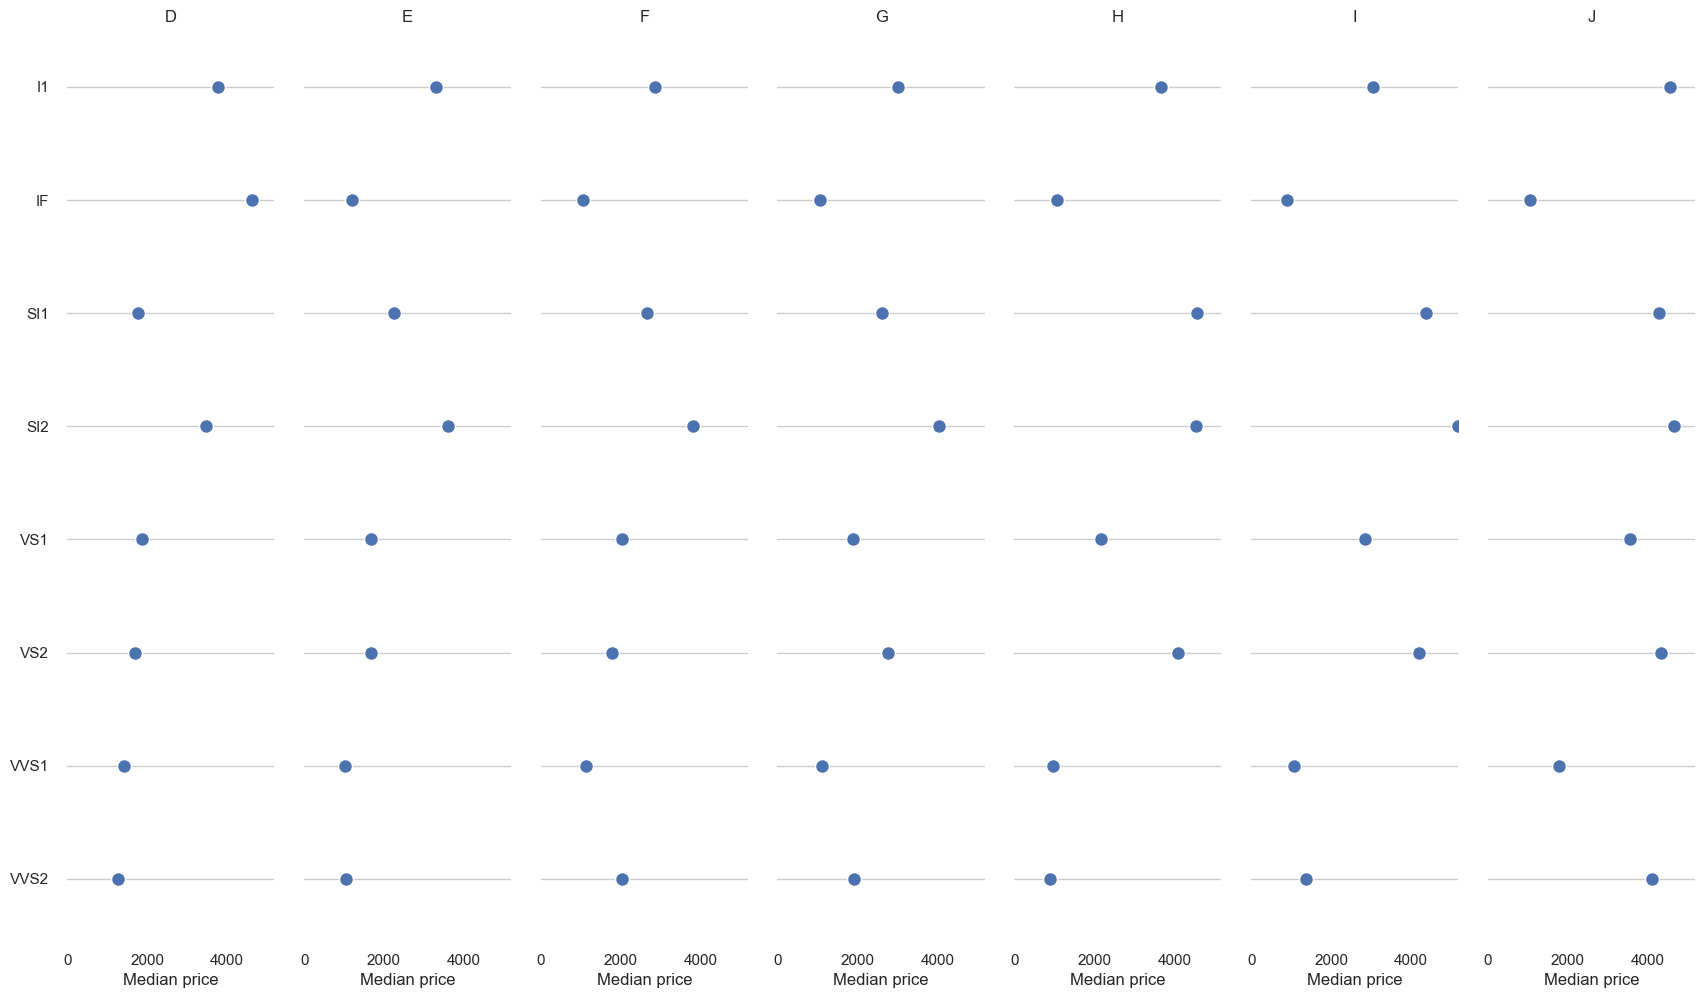

In [69]:
sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(data_c,
                 x_vars=data_c.columns[1:], y_vars=["clarity"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-5, max(data_c.max(axis = 1)) + 10), xlabel="Median price", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['D','E','F','G','H','I','J']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

### New features

In [240]:
for name in ['feature_1','feature_2','feature_3','feature_4']:
    df[name] = 0

df.loc[((df['x'] >= 6.41) & (df['x'] < 6.68) & (df['z'] >= 2.69)),'feature_1'] = 1
df.loc[(df['x'] >= 6.41) & (df['x'] < 6.68) & ((df['y'] < 4.54) | (df['y'] >= 4.82)),'feature_2'] = 1
df.loc[(df['y'] < 6.07) & ((df['x'] < 5.22) | (df['x'] >= 5.68)),'feature_3'] = 1
df.loc[(df['x'] >= 6.41) & (df['x'] < 6.68) & (df['z'] >= 2.69),'feature_4'] = 1

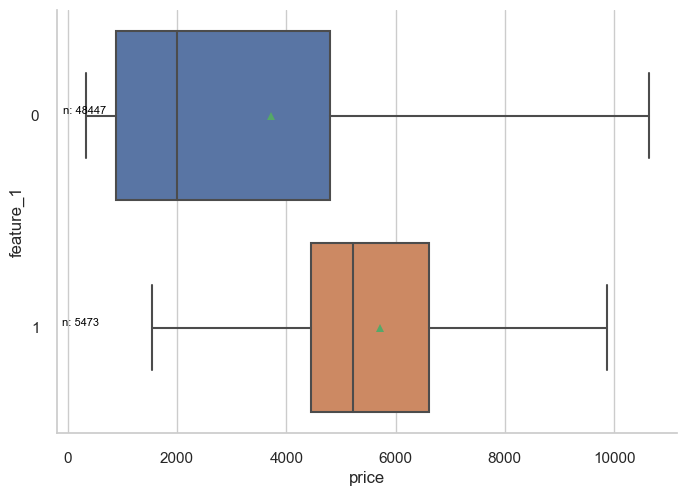

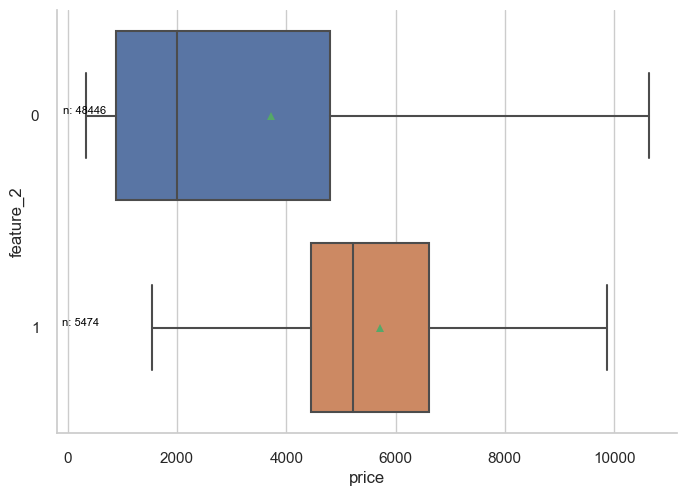

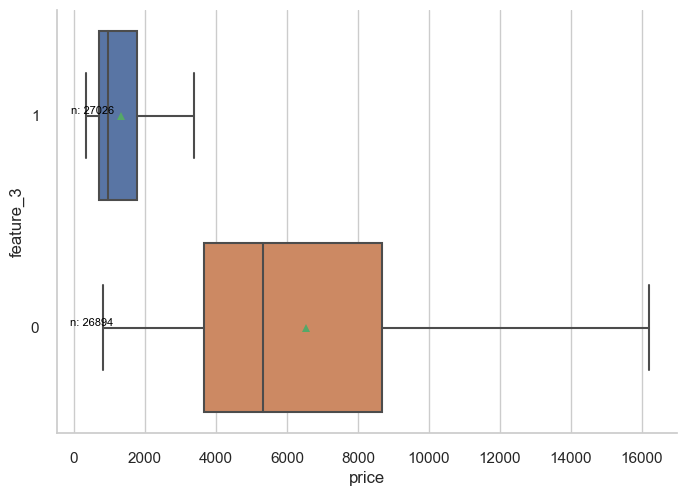

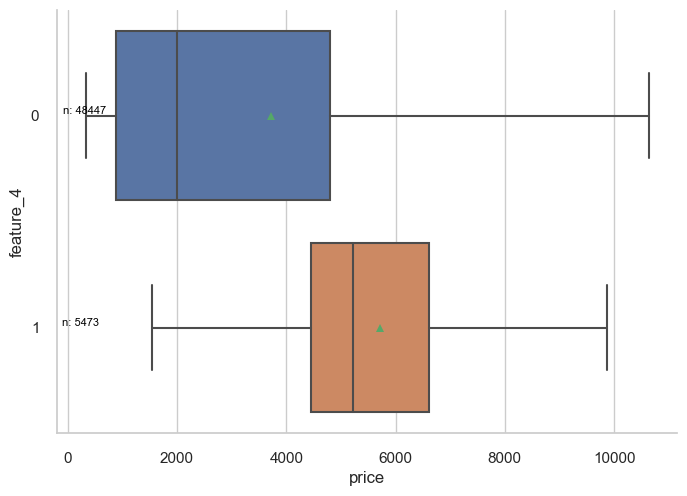

In [175]:
for name in [col for col in df.columns if 'feature_' in col]:

    dfa = df.copy()
    dfa[name] = dfa[name].astype(str)

    ax = sns.boxplot(x="price", y=name, data=dfa, showfliers = False, showmeans = True)
    medians = dfa.groupby([name])['price'].median().values
    medians = np.array([-80, -80])
    nobs = dfa[name].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_yticklabels()):
        ax.text(medians[tick],tick,nobs[tick],color='black', verticalalignment = "bottom", size=8, fontdict=None)
    sns.despine()
    plt.show();

### Prediction

In [300]:
mod_data = df.copy()

In [301]:
a = pd.DataFrame(mod_data.isna().mean().round(4) * 100, columns = ['Count'])
a[a.Count > 0]

,Count


In [302]:
y = mod_data.price
X = mod_data.drop(['price','carat','feature_3'], axis = 1)
X.head()

,cut,color,clarity,depth,table,x,y,z,xy_ratio,xz_ratio,yz_ratio,size,feature_1,feature_2,feature_4
0,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,0.992462,1.625514,1.637860,38.202030,0,0,0
1,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,1.013021,1.683983,1.662338,34.505856,0,0,0
2,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,0.995086,1.753247,1.761905,38.076885,0,0,0
3,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,0.992908,1.596958,1.608365,46.724580,0,0,0
4,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,0.997701,1.578182,1.581818,51.917250,0,0,0


#### Test-Train split

In [303]:
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

The least populated class in y has only 1 members, which is less than n_splits=5.


TRAIN: [    1     2     3 ... 53917 53918 53919] TEST: [    0     5    10 ... 53881 53900 53901]
TRAIN: [    0     2     3 ... 53917 53918 53919] TEST: [    1     6    11 ... 53902 53903 53909]
TRAIN: [    0     1     3 ... 53917 53918 53919] TEST: [    2     7    12 ... 53910 53911 53912]
TRAIN: [    0     1     2 ... 53917 53918 53919] TEST: [    3     8    13 ... 53913 53914 53915]
TRAIN: [    0     1     2 ... 53913 53914 53915] TEST: [    4     9    15 ... 53917 53918 53919]
(43136, 15) (10784, 15) (43136,) (10784,)


#### Infilling

In [74]:
#check = X_train.groupby("neighbourhood_group")["reviews_per_month"].mean()
#X_train["reviews_per_month"] = X_train.groupby("neighbourhood_group")["reviews_per_month"].transform(lambda x: x.fillna(x.mean()))
#X_test["reviews_per_month"] = X_train.groupby("neighbourhood_group")["reviews_per_month"].transform(lambda x: x.fillna(x.mean()))
#check

In [20]:
#a = pd.DataFrame(X_train.isna().mean().round(4) * 100, columns = ['Count'])
#a[a.Count > 0]

,Count


#### New features (not needed to rerun)

In [161]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))
num_cols = num_cols + ['price']
num_cols.remove('carat')

X_train_b = pd.concat([X_train,y_train], axis = 1)

for m_val in num_cols:
    X_train_b[m_val + '_bin'], bin_edges  = pd.qcut(X_train_b[m_val],
                                                   q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                   retbins = True,
                                                   duplicates = 'drop')
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train_b[m_val + '_bin']  = pd.cut(X_train_b[m_val],
                                       bins = bin_edges,
                                       labels = range(len(bin_edges)-1),
                                       duplicates = 'drop',
                                       include_lowest=True)
    X_train_b[m_val + '_bin']  = X_train_b[m_val + '_bin'].astype(str)
    X_train_b.loc[X_train_b[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

z [1.07 2.69 2.79 2.98 3.22 3.52 3.75 3.98 4.12 4.52 6.98] range(0, 10)
x [ 3.73  4.35  4.54  4.82  5.22  5.68  6.07  6.41  6.68  7.3  10.74] range(0, 10)
table [44. 55. 56. 57. 58. 59. 60. 95.] range(0, 7)
y [ 3.71  4.36  4.54  4.82  5.23  5.7   6.07  6.42  6.69  7.3  10.54] range(0, 10)
depth [43.  60.  60.8 61.3 61.6 61.8 62.1 62.3 62.7 63.2 79. ] range(0, 10)
price [  326.    646.    837.   1087.   1698.   2401.   3464.   4662.   6300.
  9817.5 18823. ] range(0, 10)


In [162]:
cat_cols = X_train.select_dtypes(include=np.object).columns.tolist()
print(cat_cols)

['cut', 'color', 'clarity']


`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [163]:
bin_m_data = [col for col in X_train_b.columns if '_bin' in col and '_miss_' not in col]
print(bin_m_data)
X_train_b[bin_m_data + cat_cols].head()

['z_bin', 'x_bin', 'table_bin', 'y_bin', 'depth_bin', 'price_bin']


,z_bin,x_bin,table_bin,y_bin,depth_bin,price_bin,cut,color,clarity
0,0,0,0,0,3,0,Ideal,E,SI2
1,0,0,6,0,0,0,Premium,E,SI1
2,0,0,6,0,0,0,Good,E,VS1
3,0,0,3,0,7,0,Premium,I,VS2
5,0,0,2,0,8,0,Very Good,J,VVS2


In [164]:
pd.crosstab(X_train_b.price_bin, columns = 'Count')
X_train_b.loc[(X_train_b.price_bin.isin(['0','1'])),'price_class'] = 0
X_train_b.loc[(X_train_b.price_bin.isin(['8','9'])),'price_class'] = 1
pd.crosstab(X_train_b.price_class, columns = 'Count')

col_0,Count
price_class,
0.0,8634
1.0,8626


In [165]:
bin_m_data.remove('price_bin')
#cat_cols.remove('Country')
a = bin_m_data + cat_cols
a.sort()
print(a)

['clarity', 'color', 'cut', 'depth_bin', 'table_bin', 'x_bin', 'y_bin', 'z_bin']


In [166]:
print(X_train_b.shape)
X_train_b = X_train_b[~X_train_b.price_class.isna()]
print(X_train_b.shape)
y = X_train_b.price_class
X = X_train_b[bin_m_data + cat_cols]

(43136, 17)
(17260, 17)


In [167]:
ohe = OneHotEncoder()

ohe.fit(X)
colnames = ohe.get_feature_names_out(list(X.columns))

bin_data_train = ohe_dset(X,list(X.columns))
print(bin_data_train.shape)

(17260, 67)
(17260, 67)


In [168]:
print(list(bin_data_train.columns))

['z_bin_0', 'z_bin_1', 'z_bin_2', 'z_bin_3', 'z_bin_4', 'z_bin_5', 'z_bin_6', 'z_bin_7', 'z_bin_8', 'z_bin_9', 'x_bin_0', 'x_bin_1', 'x_bin_2', 'x_bin_3', 'x_bin_4', 'x_bin_5', 'x_bin_6', 'x_bin_7', 'x_bin_8', 'x_bin_9', 'table_bin_0', 'table_bin_1', 'table_bin_2', 'table_bin_3', 'table_bin_4', 'table_bin_5', 'table_bin_6', 'y_bin_0', 'y_bin_1', 'y_bin_2', 'y_bin_3', 'y_bin_4', 'y_bin_5', 'y_bin_6', 'y_bin_7', 'y_bin_8', 'y_bin_9', 'depth_bin_0', 'depth_bin_1', 'depth_bin_2', 'depth_bin_3', 'depth_bin_4', 'depth_bin_5', 'depth_bin_6', 'depth_bin_7', 'depth_bin_8', 'depth_bin_9', 'cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']


In [169]:
clf = DecisionTreeClassifier(max_depth=5, random_state=1234)
model = clf.fit(bin_data_train, y)

text_representation = tree.export_text(clf, feature_names=list(bin_data_train.columns))

In [170]:
rule_lst = []
flattened_lst = []
flattened_lsts = []

for split_size in tqdm([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    X_trees, X_tree_test, y_trees, y_tree_test = train_test_split(bin_data_train,
                                                                  y,
                                                                  test_size = split_size,
                                                                  stratify = y,
                                                                  random_state = 222)
    print(X_trees.shape, y_trees.shape)
    
    model = clf.fit(X_trees, y_trees)
    text_representation = tree.export_text(clf, feature_names=list(X_trees.columns))
    rules, proba = get_rules(clf, list(X_trees.columns), [0,1], 60, 100)
    rule_lst.append(list(set(rules)))
    flattened_lst = [val for sublist in rule_lst for val in sublist]
    flattened_lst = list(set(flattened_lst))

for i in range(len(flattened_lst)):
    flattened_lsts.append(flattened_lst[i].split(' then class')[0])
flattened_lsts = list(set(flattened_lsts))

 25%|██▌       | 2/8 [00:00<00:00, 18.39it/s]

(15534, 67) (15534,)
(13808, 67) (13808,)
(12082, 67) (12082,)
(10356, 67) (10356,)
(8630, 67) (8630,)


100%|██████████| 8/8 [00:00<00:00, 24.90it/s]

(6904, 67) (6904,)
(5178, 67) (5178,)
(3452, 67) (3452,)


In [171]:
flattened_lsts

['if (x_bin_9 <= 0.5) and (x_bin_8 > 0.5)',
 'if (y_bin_9 > 0.5)',
 'if (y_bin_9 <= 0.5) and (y_bin_8 <= 0.5) and (y_bin_7 <= 0.5) and (y_bin_6 <= 0.5) and (y_bin_4 <= 0.5)',
 'if (y_bin_9 <= 0.5) and (y_bin_8 <= 0.5) and (y_bin_7 > 0.5)',
 'if (y_bin_9 <= 0.5) and (y_bin_8 <= 0.5) and (y_bin_7 <= 0.5) and (y_bin_6 <= 0.5) and (y_bin_5 <= 0.5)',
 'if (x_bin_9 <= 0.5) and (x_bin_8 <= 0.5) and (x_bin_7 <= 0.5) and (x_bin_6 > 0.5)',
 'if (x_bin_9 <= 0.5) and (x_bin_8 <= 0.5) and (x_bin_7 > 0.5) and (z_bin_0 <= 0.5)',
 'if (x_bin_9 > 0.5)',
 'if (y_bin_9 <= 0.5) and (y_bin_8 <= 0.5) and (y_bin_7 <= 0.5) and (y_bin_6 <= 0.5) and (x_bin_4 <= 0.5)',
 'if (x_bin_9 <= 0.5) and (x_bin_8 <= 0.5) and (x_bin_7 <= 0.5) and (x_bin_6 <= 0.5) and (x_bin_5 <= 0.5)',
 'if (y_bin_9 <= 0.5) and (y_bin_8 <= 0.5) and (y_bin_7 <= 0.5) and (y_bin_6 > 0.5)',
 'if (x_bin_9 <= 0.5) and (x_bin_8 <= 0.5) and (x_bin_7 > 0.5) and (y_bin_2 <= 0.5)',
 'if (y_bin_9 <= 0.5) and (y_bin_8 > 0.5)']

#### Binning data

In [304]:
m_val_lst = ['x','y','z']

for m_val in m_val_lst:
    check = X_train[~X_train[m_val].isna()]
    check[m_val + '_bin'], bin_edges  = pd.qcut(check[m_val],
                                                   q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                   retbins = True,
                                                   duplicates = 'drop')
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train[m_val + '_bin']  = pd.cut(X_train[m_val],
                                       bins = bin_edges,
                                       labels = range(len(bin_edges)-1),
                                       duplicates = 'drop',
                                       include_lowest=True)
    X_train[m_val + '_bin']  = X_train[m_val + '_bin'].astype(str)
    X_train.loc[X_train[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

    ### Test data ###
    X_test[m_val + '_bin'] = pd.cut(X_test[m_val],
                                    bins = bin_edges,
                                    labels = range(len(bin_edges)-1),
                                    include_lowest=True)

    X_test[m_val + '_bin'] = X_test[m_val + '_bin'].astype('str')
    X_test.loc[X_test[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

X_train = X_train.drop(m_val_lst, axis = 1)
X_test = X_test.drop(m_val_lst, axis = 1)

x [ 3.73  4.35  4.54  4.82  5.22  5.68  6.07  6.41  6.68  7.3  10.74] range(0, 10)
y [ 3.71  4.36  4.54  4.82  5.23  5.7   6.07  6.42  6.69  7.3  10.54] range(0, 10)
z [1.07 2.69 2.79 2.98 3.22 3.52 3.75 3.98 4.12 4.52 6.98] range(0, 10)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [305]:
#pd.crosstab(X_train.reviews_per_month_bin, columns = 'Count')

#### Numeric data

In [306]:
#pd.crosstab(X_train.gender,columns = 'Count')

In [307]:
#pd.crosstab(X_test.gender,columns = 'Count')

In [308]:
#########################################
### Check for single non varying data ###
#########################################

lst = []
for name in list(X_train.columns):
    if (X_train[name].nunique() == 1):
        lst.append(name)

print(lst)

[]


In [309]:
try:
    X_train = X_train.drop(lst, axis=1)
    X_test = X_test.drop(lst, axis=1)
except:
    X_train = X_train
    X_test = X_test

In [310]:
#########################
### Multicollinearity ###
#########################

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

vif = calculate_vif(X_train[num_cols])

a = vif[(vif.VIF > 10)]
to_drop_vif = list(a.Features)
print(to_drop_vif)
vif = vif.sort_values(['VIF'], ascending = False)
vif

['depth', 'table', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'feature_1', 'feature_2', 'feature_4']


divide by zero encountered in double_scalars


,Features,VIF
6,feature_1,inf
8,feature_4,inf
3,xz_ratio,5.362524e+04
4,yz_ratio,2.809671e+04
2,xy_ratio,2.804318e+04
7,feature_2,9.274701e+03
0,depth,8.272276e+03
1,table,7.868564e+02
5,size,4.231955e+00


In [29]:
try:
    X_train = X_train.drop(to_drop_vif, axis=1)
    X_test = X_test.drop(to_drop_vif, axis=1)
except:
    X_train = X_train
    X_test = X_test

In [311]:
import statsmodels.api as sm

O = y_train
# To estimate the effect the addition/removal of a feature C
# has on the relationship between an independent feature I and an outcome O

conf = []
for I in num_cols:
    # build a baseline model for the  effect of I on  O
    model = sm.OLS(O, sm.add_constant(X_train[I])).fit()
    IO_coef, IO_sig = model.params[I], model.pvalues[I]

    ## Access the effect of 
    for C in num_cols:
        if C != I:
            # build an auxilliary model adding C to the relationship between I and O
            model2 = sm.OLS(O, sm.add_constant(X_train[[I, C]])).fit()
            ico_preds = model2.predict()
            ICO_coef, ICO_sig = model2.params[I], model2.pvalues[I]

            # build a baseline model for the effect of C on  O
            model3 = sm.OLS(O, sm.add_constant(X_train[C])).fit()
            CO_coef, CO_sig = model3.params[C], model3.pvalues[C]

            corr_IC, _ = stats.pearsonr(X_train[I], X_train[C]) # CORR The independent vs the control
            corr_IO, _ = stats.pearsonr(X_train[I], O) #CORR The independent vs the outcome
            corr_CO, _ = stats.pearsonr(X_train[C], O) #CORR The control vs the outcome
            conf.append({"I_C":f"{I}_{C}",
                                "IO_coef":IO_coef, "IO_sig":IO_sig,
                                "CO_coef":CO_coef, "CO_sig":CO_sig,
                                "ICO_sig":ICO_sig, "ICO_coef": ICO_coef,
                                "corr_IC":corr_IC,
                                "corr_IO":corr_IO,
                                "corr_CO":corr_CO})

cc = pd.DataFrame(conf)
corr_ic = (cc['corr_IC'] > 0.5) | (cc['corr_IC'] < -0.5) # I is correlated with C
corr_co = (cc['corr_CO'] > 0.5) | (cc['corr_CO'] < -0.5) # C is correlated with O
corr_io = (cc['corr_IO'] > 0.5) | (cc['corr_IO'] < -0.5) # C is correlated with O

## C and O are significantly correlated
co_sig = (cc['CO_sig'] < 0.01) # The C is independetly predictive of O
io_sig = (cc['IO_sig'] < 0.01)

cc[corr_ic & corr_io & corr_co & co_sig & io_sig]

,I_C,IO_coef,IO_sig,CO_coef,CO_sig,ICO_sig,ICO_coef,corr_IC,corr_IO,corr_CO


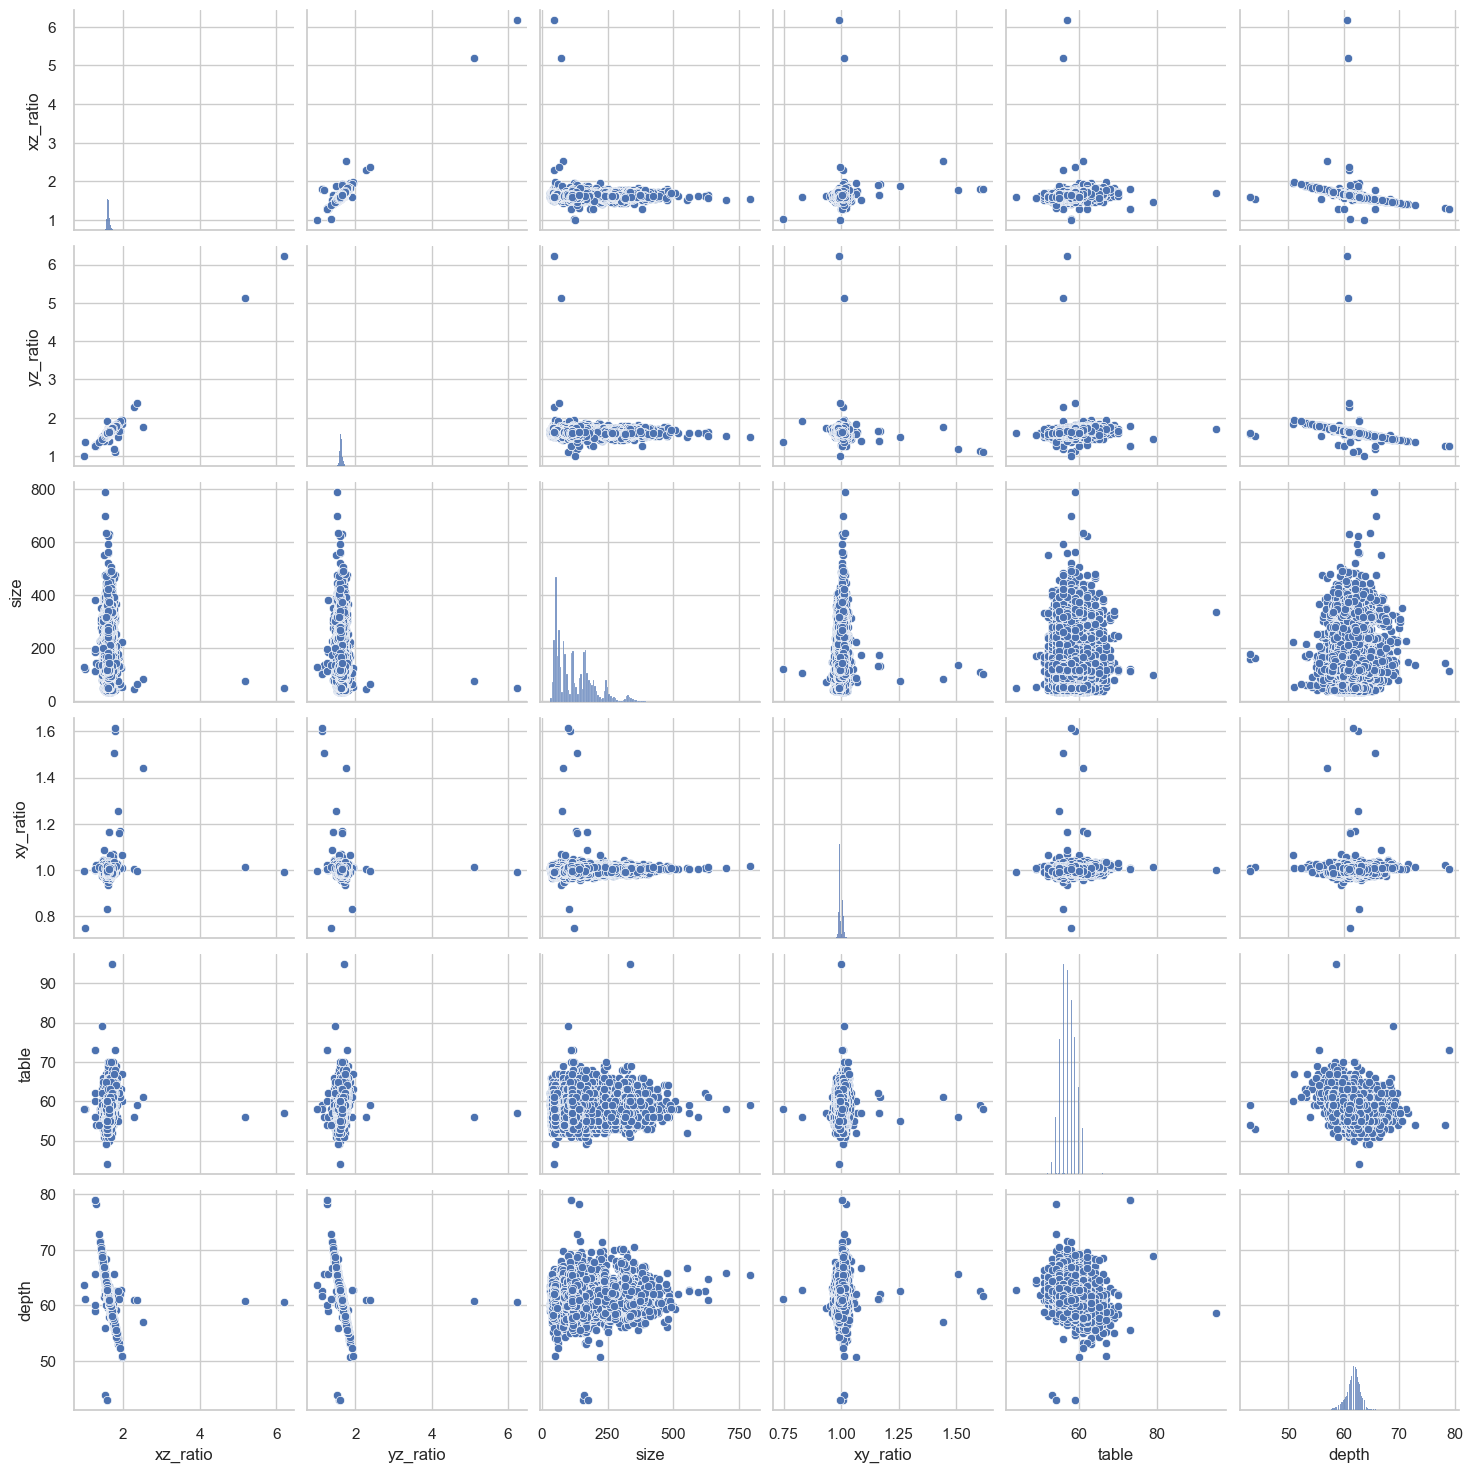

In [312]:
num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))

sns.pairplot(X_train[num_cols])
plt.show();

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


['yz_ratio', 'price']


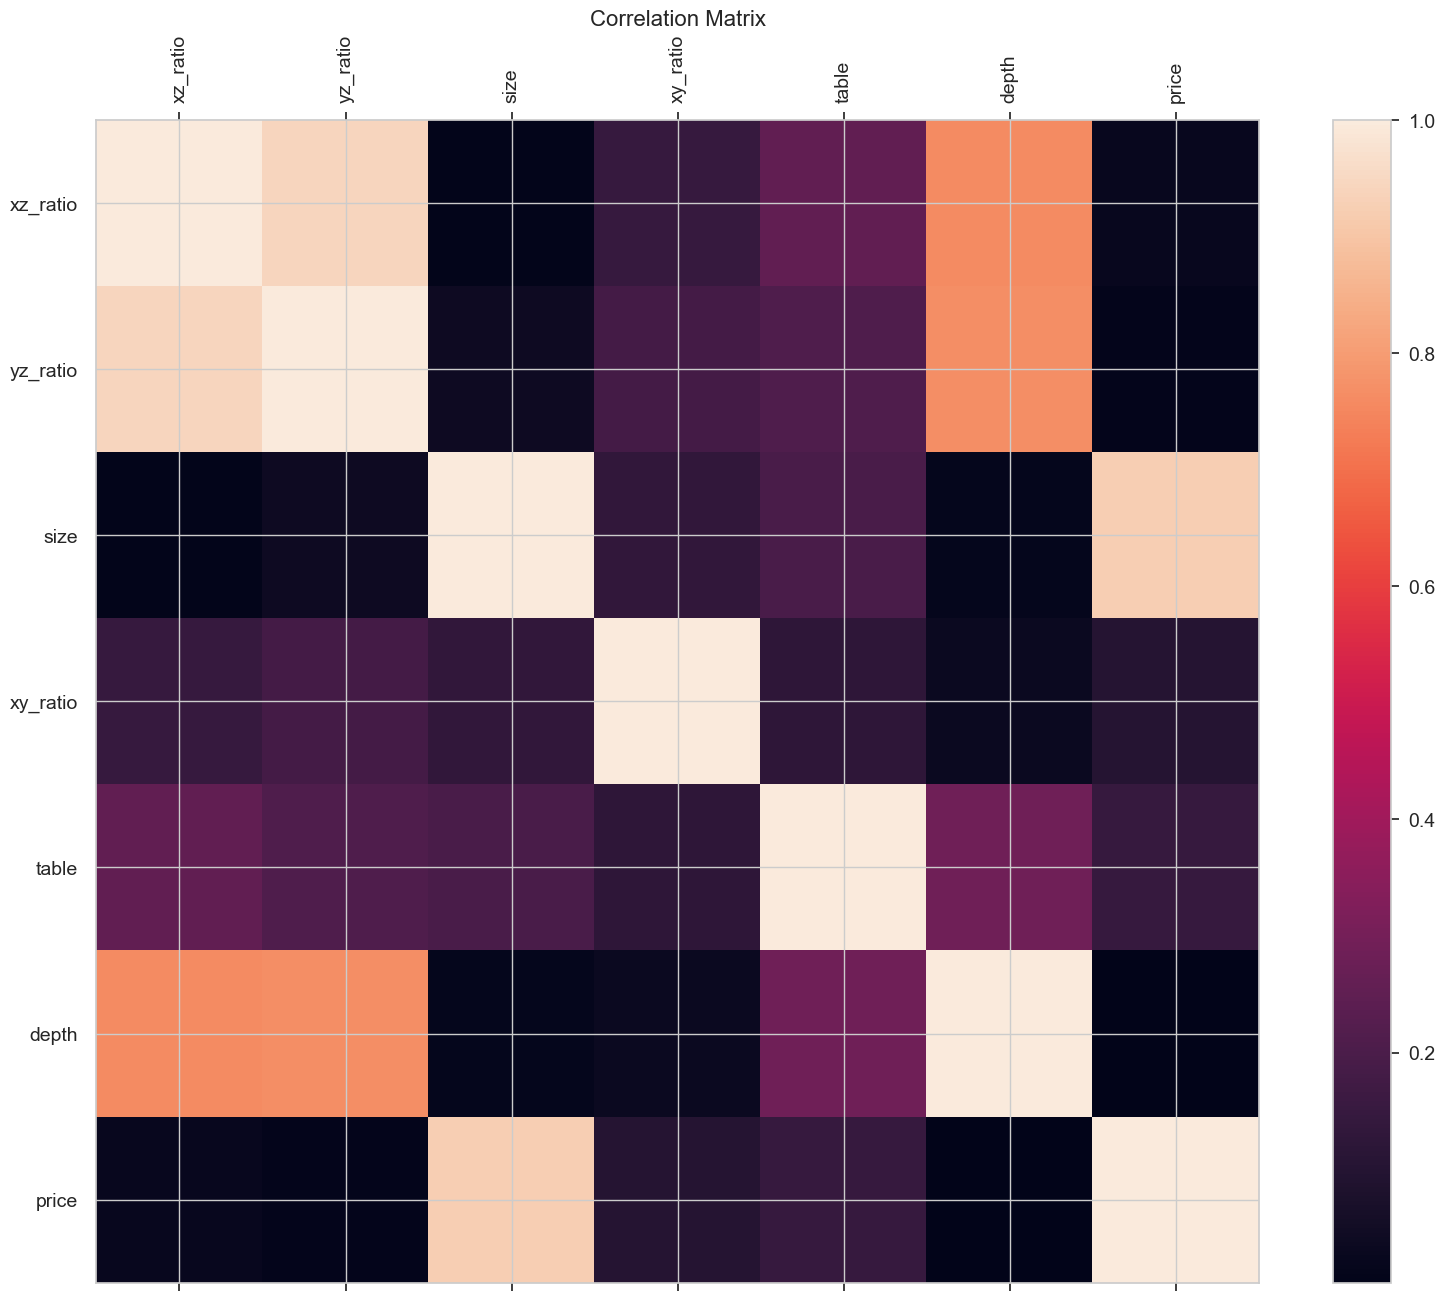

In [313]:
###################
### Correlation ###
###################

corre_data = pd.concat([X_train[num_cols],
                        pd.DataFrame(y_train)],
                       axis = 1)

cor_matrix = corre_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number)
plt.xticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show();

In [314]:
cor_matrix

,xz_ratio,yz_ratio,size,xy_ratio,table,depth,price
xz_ratio,1.000000,0.942596,0.008256,0.150212,0.255610,0.760905,0.022965
yz_ratio,0.942596,1.000000,0.039649,0.185312,0.209774,0.768059,0.013813
size,0.008256,0.039649,1.000000,0.133654,0.194263,0.016881,0.925467
xy_ratio,0.150212,0.185312,0.133654,1.000000,0.125123,0.033326,0.102823
table,0.255610,0.209774,0.194263,0.125123,1.000000,0.290238,0.149275
depth,0.760905,0.768059,0.016881,0.033326,0.290238,1.000000,0.002568
price,0.022965,0.013813,0.925467,0.102823,0.149275,0.002568,1.000000


In [315]:
to_drop_vif = ['size','yz_ratio']

try:
    X_train = X_train.drop(to_drop_vif, axis=1)
    X_test = X_test.drop(to_drop_vif, axis=1)
except:
    X_train = X_train
    X_test = X_test

In [316]:
#####################
### MinMax scaler ###
#####################

num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))

print(X_train[num_cols].shape)

transformer_train = MinMaxScaler().fit(X_train[num_cols])
num_data_train = pd.DataFrame(transformer_train.transform(X_train[num_cols]))
num_data_train.columns = num_cols
print(num_data_train.shape)

num_data_test = minmax_dset(X_test,num_cols) ### Test ###

(43136, 4)
(43136, 4)
(10784, 4)


#### Categorical data

In [317]:
cat_cols = list(X_train.select_dtypes(include=['object']))
cat_cols = (list(set(cat_cols) - set([col for col in X_train.columns if '_bin' in col])))
cat_cols = (list(set(cat_cols) - set([col for col in X_train.columns if 'feature_' in col])))
print(cat_cols)

['clarity', 'color', 'cut']


In [318]:
###################################
### High cardinality adjustment ###
###################################

card_vars = []
cat_data = X_train[cat_cols]
for i in range(cat_data.shape[1]):
    X_train.loc[X_train[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'
    X_test.loc[X_test[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'

    if (cat_data.iloc[:,i].nunique() > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        X_train.loc[~X_train[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'
        X_test.loc[~X_test[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'

    if (len(list(set(cat_data.iloc[:,i]))) > 100):
        card_vars.append(cat_data.columns[i])

print(card_vars)

[]


In [319]:
########################
### One hot encoding ###
########################

ohe = OneHotEncoder()
print(X_train.shape)
# (1808, 10)

### Train ###

ohe.fit(X_train[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_train = ohe_dset(X_train,cat_cols)  ### Train ###
cat_data_test = ohe_dset(X_test,cat_cols)    ### Test ###

(43136, 13)
(43136, 20)
(10784, 20)


#### Bin data

In [320]:
bin_data_cols = [col for col in X_train.columns if 'feature_' in col]
print(bin_data_cols)

['feature_1', 'feature_2', 'feature_4']


In [321]:
bin_data_train = X_train[bin_data_cols]
bin_data_test = X_test[bin_data_cols]

print(bin_data_train.shape)

(43136, 3)


#### Ordinal data

In [322]:
[col for col in X_train.columns if '_bin' in col]

['x_bin', 'y_bin', 'z_bin']

In [323]:
ordinal_encoder_bin = OrdinalEncoder(categories=[['Missing','0','1','2','3','4','5','6','7','8','9']])
ordinal_encoder_bin.fit(pd.DataFrame(X_train['x_bin']))
ord_data_train = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['x_bin'])),columns = ['x_bin'])
ord_data_test = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['x_bin'])), columns = ['x_bin'])

ordinal_encoder_bin.fit(pd.DataFrame(X_train['y_bin']))
ord_data_train['y_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_train['y_bin']))
ord_data_test['y_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_test['y_bin']))

ordinal_encoder_bin.fit(pd.DataFrame(X_train['z_bin']))
ord_data_train['z_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_train['z_bin']))
ord_data_test['z_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_test['z_bin']))

for name in ['x_bin', 'y_bin', 'z_bin']:
    ord_data_train[name] = ord_data_train[name].astype(int)

transformer_train_o = MinMaxScaler().fit(ord_data_train)
ord_data_train = pd.DataFrame(transformer_train_o.transform(ord_data_train))
ord_data_train.columns = ['x_bin', 'y_bin', 'z_bin']

print(
    f'Training data min:max {ord_data_train.min().min(),ord_data_train.max().max()}')

for name in ['x_bin', 'y_bin', 'z_bin']:
    ord_data_test[name] = ord_data_test[name].astype(int)

transformer_test_o = MinMaxScaler().fit(ord_data_test)
ord_data_test = pd.DataFrame(transformer_test_o.transform(ord_data_test))
ord_data_test.columns = ['x_bin', 'y_bin', 'z_bin']

print(
    f'Test data min:max {ord_data_test.min().min(),ord_data_test.max().max()}')

Training data min:max (0.0, 1.0)
Test data min:max (0.0, 1.0)


In [324]:
print(list(cat_data_train.columns))

print(list(num_data_train.columns))

print(list(bin_data_train.columns))

print(list(ord_data_train.columns))

['clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2', 'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good']
['table', 'xz_ratio', 'depth', 'xy_ratio']
['feature_1', 'feature_2', 'feature_4']
['x_bin', 'y_bin', 'z_bin']


In [325]:
###########################
### Bring data together ###
###########################

print(cat_data_train.shape, num_data_train.shape, bin_data_train.shape, ord_data_train.shape)
cat_data_train = cat_data_train.reset_index()
num_data_train = num_data_train.reset_index()
bin_data_train = bin_data_train.reset_index()
ord_data_train = ord_data_train.reset_index()

X_train = pd.concat([cat_data_train,num_data_train],axis = 1)
print(X_train.shape)
X_train = pd.concat([X_train,bin_data_train],axis = 1)
print(X_train.shape)
X_train = pd.concat([X_train,ord_data_train],axis = 1)

print(cat_data_test.shape, num_data_test.shape, bin_data_test.shape, ord_data_test.shape)
cat_data_test = cat_data_test.reset_index()
num_data_test = num_data_test.reset_index()
bin_data_test = bin_data_test.reset_index()
ord_data_test = ord_data_test.reset_index()
X_test = pd.concat([cat_data_test,num_data_test],axis = 1)
X_test = pd.concat([X_test,bin_data_test],axis = 1)
X_test = pd.concat([X_test,ord_data_test],axis = 1)

print(X_train.shape, X_test.shape)

# (39116, 60) (9779, 60)

(43136, 20) (43136, 4) (43136, 3) (43136, 3)
(43136, 26)
(43136, 30)
(10784, 20) (10784, 4) (10784, 3) (10784, 3)
(43136, 34) (10784, 34)


In [326]:
####################################################
### Check that train/test sets have same columns ###
####################################################

mod_cols = (list(set(list(X_train.columns)) - set(['index'])))
X_train = X_train[mod_cols]
miss_lst = list(set(list(X_train.columns)) - set(list(X_test.columns)))

for name in miss_lst:
    X_test[name] = 0
X_test = X_test[list(X_train.columns)]

drop_test_lst = list(set(list(X_test.columns)) - set(list(X_train.columns)))
X_test = X_test.drop(drop_test_lst, axis = 1)

print(X_train.shape, X_test.shape)
# (39082, 70) (9770, 70)

(43136, 30) (10784, 30)


#### Mutual information check

In [327]:
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns

In [328]:
mutual_info = mutual_info.sort_values(ascending=False)
mutual_info[:20]

y_bin           1.387870
x_bin           1.379248
z_bin           1.332580
xy_ratio        0.599628
feature_1       0.129980
feature_2       0.128368
feature_4       0.125421
clarity_SI1     0.101534
clarity_VS2     0.092064
clarity_SI2     0.083037
color_E         0.077605
xz_ratio        0.074173
cut_Ideal       0.068848
color_F         0.068139
color_G         0.067147
color_D         0.066794
clarity_VVS2    0.062980
table           0.061712
clarity_VVS1    0.058160
clarity_VS1     0.054068
dtype: float64

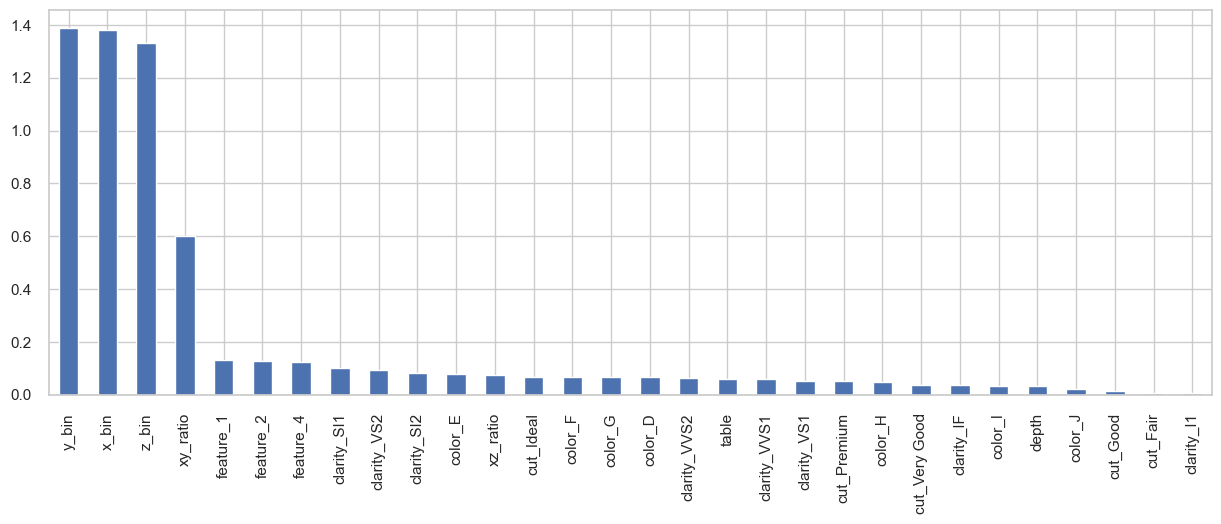

In [329]:
mutual_info[:50].sort_values(ascending=False).plot.bar(figsize=(15,5))
plt.show()

### Clustering

In [330]:
clust_data = df[~df.isnull().any(axis=1)]
print(clust_data.shape)
print(list(clust_data.columns))

(53920, 18)
['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'size', 'feature_1', 'feature_2', 'feature_3', 'feature_4']


In [332]:
#clust_data = clust_data.drop(['name','host_id'], axis = 1)

cat_cols = list(clust_data.select_dtypes(include=['object']))
print('Object data: ', cat_cols)

print('Datetime data: ',list(clust_data.select_dtypes(include=['datetime']).columns))

print('Timedelta data: ',list(clust_data.select_dtypes(include=['timedelta']).columns))

num_cols = list(clust_data.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
print('Numeric data: ', num_cols)

Object data:  ['cut', 'color', 'clarity']
Datetime data:  []
Timedelta data:  []
Numeric data:  ['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'size', 'feature_1', 'feature_2', 'feature_3', 'feature_4']


In [333]:
num_data = clust_data[list(clust_data.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)]
print(num_data.shape)
# (74869, 21)
num_data.describe()

(53920, 15)


,carat,depth,table,price,x,y,z,xy_ratio,xz_ratio,yz_ratio,size,feature_1,feature_2,feature_3,feature_4
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797682,61.749483,57.457007,3930.845122,5.731606,5.733429,3.539405,0.999457,1.619991,1.620971,129.801598,0.101502,0.101521,0.501224,0.101502
std,0.473764,1.432323,2.234127,3987.113705,1.119371,1.111241,0.691601,0.010455,0.048166,0.048622,76.448314,0.301995,0.302020,0.500003,0.301995
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000,0.749169,0.990119,0.996047,31.707984,0.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000,0.992625,1.598315,1.599432,65.189759,0.000000,0.000000,0.000000,0.000000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,0.995745,1.615854,1.618750,114.840180,0.000000,0.000000,1.000000,0.000000
75%,1.040000,62.500000,59.000000,5322.250000,6.540000,6.540000,4.040000,1.006944,1.637681,1.640138,170.844468,0.000000,0.000000,1.000000,0.000000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,10.540000,6.980000,1.615572,6.186916,6.233645,790.133208,1.000000,1.000000,1.000000,1.000000


In [334]:
#####################
### Normalisation ###
#####################

numerical_features = pd.DataFrame(MinMaxScaler(feature_range=(0, 1)).fit_transform(
    num_data[num_cols]), index=num_data.index, columns=num_cols)

print(
    f'Data min:max {numerical_features.min().min(),numerical_features.max().max()}')

Data min:max (0.0, 1.0000000000000002)


In [335]:
###################################
### High cardinality adjustment ###
###################################

card_vars = []
cat_data = clust_data[cat_cols]
cat_data_vals = cat_data.copy()
for i in range(cat_data.shape[1]):

    if (len(list(set(cat_data.iloc[:,i]))) > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        cat_data_vals.loc[~cat_data_vals[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'

    elif cat_data.iloc[:,i].nunique() > 100:
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))
        card_vars.append(cat_data.columns[i])

print(card_vars)

[]


In [336]:
ohe = OneHotEncoder()

transformed_dset = ohe.fit_transform(cat_data_vals[cat_cols])
cat_data = pd.DataFrame(transformed_dset.toarray())
cat_data.columns = ohe.get_feature_names_out(input_features=cat_data_vals[cat_cols].columns)

In [338]:
#cat_data = cat_data.drop(['gender_Person'], axis = 1)
print(cat_data.shape)
print(list(cat_data.columns))
print(
    f'Data min:max {cat_data.min().min(),cat_data.max().max()}')

(53920, 20)
['cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']
Data min:max (0.0, 1.0)


In [339]:
numerical_features = numerical_features.reset_index(drop=True)
cat_data = cat_data.reset_index(drop=True)
print(list(numerical_features.columns))
print(list(cat_data.columns))
all_data = pd.concat([numerical_features,cat_data], axis = 1)
print(all_data.shape)

['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'size', 'feature_1', 'feature_2', 'feature_3', 'feature_4']
['cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']
(53920, 35)


100%|██████████| 19/19 [00:22<00:00,  1.16s/it]


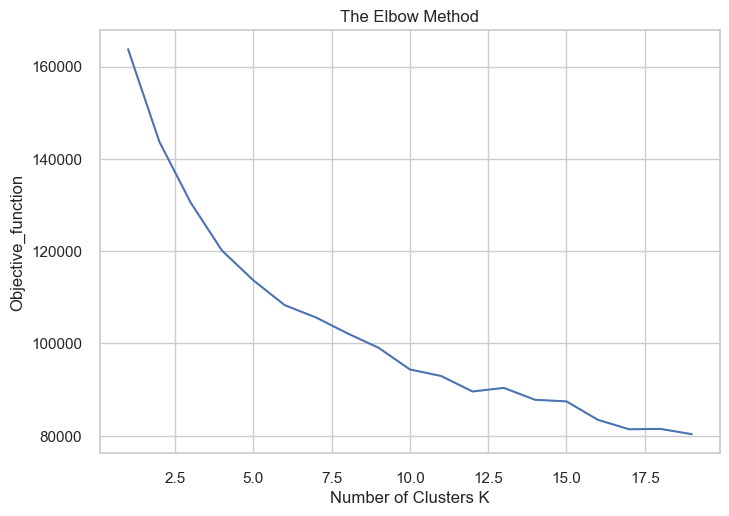

In [340]:
objective_function = []
for i in tqdm(range(1, 20)):
    clustering = KMeans(n_clusters=i, init='k-means++')
    clustering.fit(all_data)
    objective_function.append(clustering.inertia_)

plt.plot(range(1, 20), objective_function)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters K')
plt.ylabel('Objective_function')
plt.show()

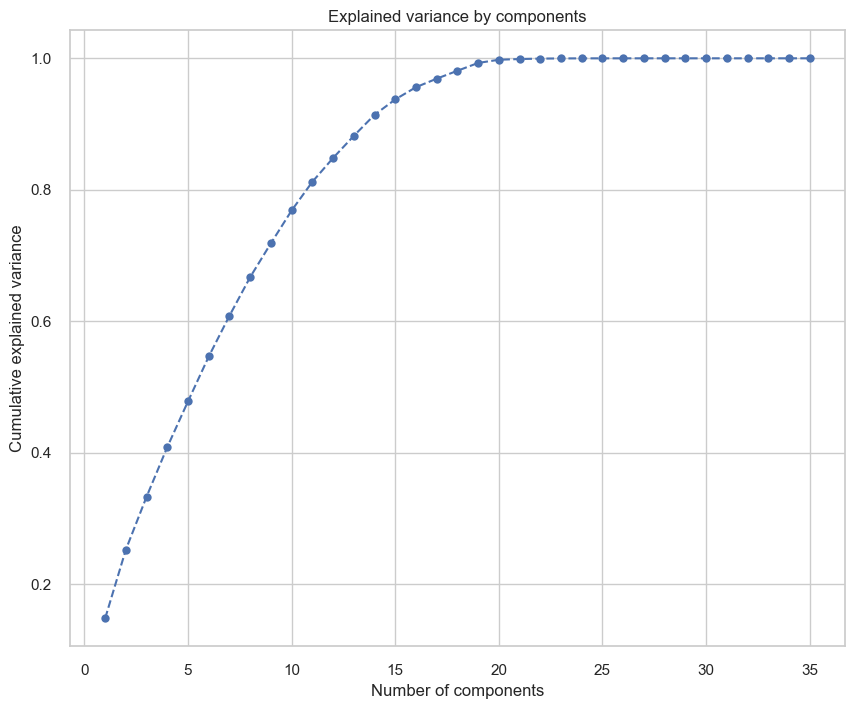

In [341]:
###########
### PCA ###
###########

pca = PCA()
pca.fit(all_data)

plt.figure(figsize=(10,8))
plt.plot(range(1,len(pca.explained_variance_ratio_.cumsum())+1), pca.explained_variance_ratio_.cumsum(),
         marker='o',linestyle='--')
plt.title("Explained variance by components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show();

In [342]:
pca = PCA(n_components=11)
pca.fit(all_data)
scores_pca = pca.transform(all_data)

100%|██████████| 39/39 [01:01<00:00,  1.57s/it]


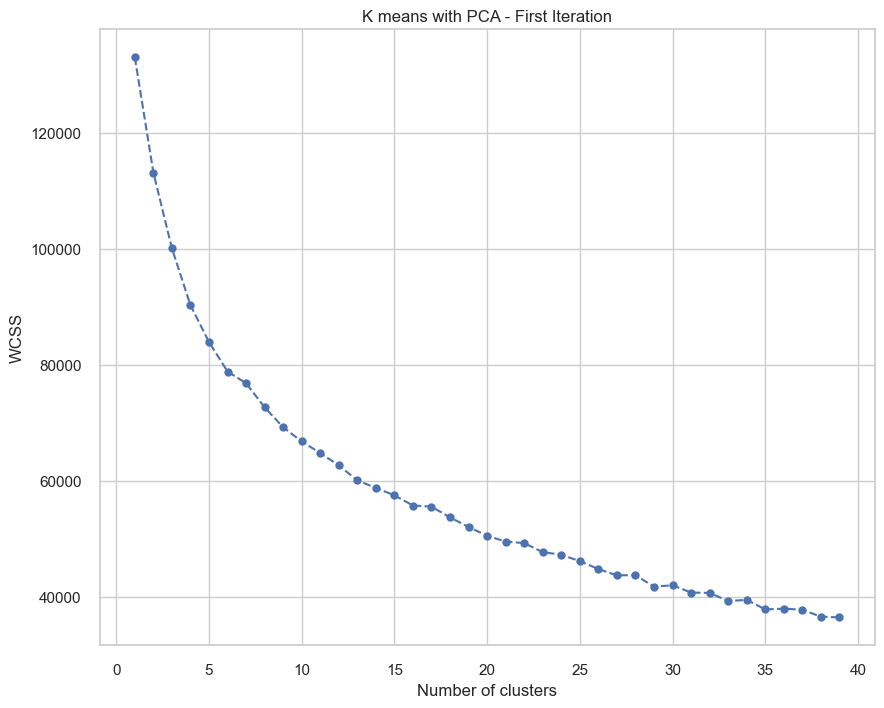

In [343]:
wcss = []
for i in tqdm(range(1,40)):
    kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(wcss)+1), wcss,
         marker='o', linestyle='--')
plt.title("K means with PCA - First Iteration")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show();

In [344]:
tuned_clustering = KMeans(n_clusters=12, init='k-means++', random_state=0)
labels = tuned_clustering.fit_predict(all_data)

metrics.silhouette_score(
    all_data, tuned_clustering.labels_, metric='euclidean')

0.1469102349288535

In [ ]:
for i in tqdm([5, 6, 7]):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(all_data)

100%|██████████| 3/3 [02:13<00:00, 44.43s/it]


In [346]:
kmeans_pca = KMeans(n_clusters=12, init="k-means++", random_state=42)
kmeans_pca.fit(scores_pca)
df_segm_pca_means = pd.concat(
    [all_data.reset_index(drop=True), pd.DataFrame(scores_pca)],axis=1)

df_segm_pca_means.columns.values[-11:] = ['Component 1', 'Component 2','Component 3',
                                         'Component 4','Component 5','Component 6', 'Component 7','Component 8',
                                         'Component 9','Component 10','Component 11']
df_segm_pca_means['Clusters'] = kmeans_pca.labels_
plt.show()

In [347]:
pd.crosstab(kmeans_pca.labels_, columns='Count')

col_0,Count
row_0,
0,4582
1,3852
2,3090
3,4742
4,5473
5,4800
6,3991
7,7154
8,5214


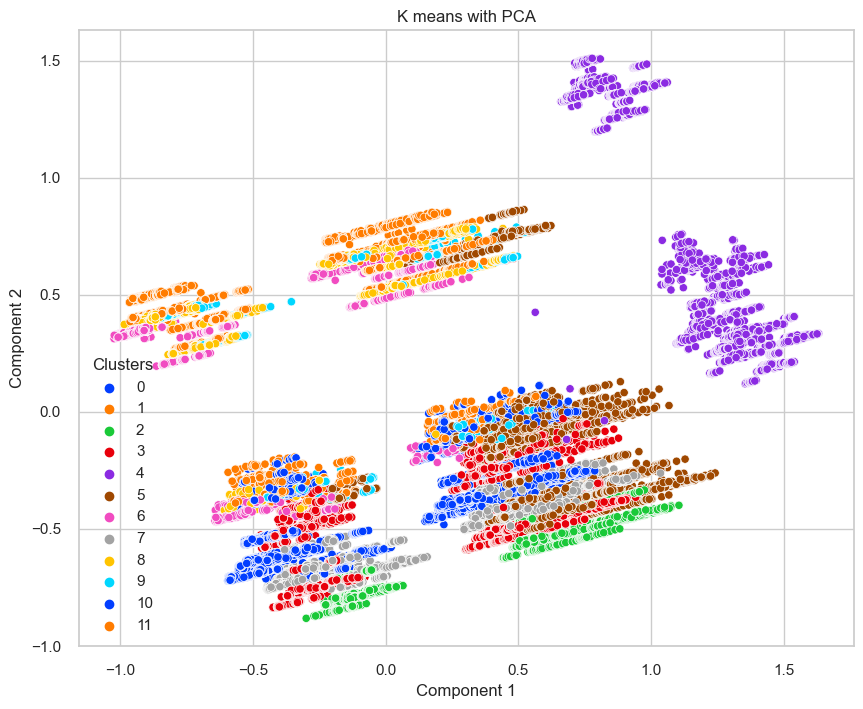

In [348]:
x_axis = df_segm_pca_means['Component 1']
y_axis = df_segm_pca_means['Component 2']
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_segm_pca_means['Clusters'], palette="bright")
plt.title("K means with PCA")
plt.show();

#### Calculate important columns

In [349]:
a = list(all_data.columns)
try:
    a.remove('index')
except:
    a = list(all_data.columns)

clust_check = df_segm_pca_means.groupby(['Clusters']).mean()
clust_checks = clust_check[a]
print(clust_checks.shape)
clust_checks

(12, 35)


,carat,depth,table,price,x,y,z,xy_ratio,xz_ratio,yz_ratio,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
Clusters,,,,,,,,,,,,,,,,,,,,,
0,0.083791,0.521604,0.283499,0.134292,0.211723,0.227960,0.365582,0.282867,0.120208,0.119945,...,0.106067,0.050415,0.014404,0.053470,0.000000,0.119162,0.383675,0.000000,0.169358,0.259930
1,0.081166,0.521177,0.255806,0.128786,0.215257,0.228861,0.366893,0.286904,0.121028,0.119676,...,0.000000,0.000000,0.016874,0.070353,0.138629,0.097871,0.184320,0.236501,0.120976,0.134476
2,0.143062,0.508963,0.303320,0.218851,0.319275,0.328623,0.436503,0.295947,0.124202,0.120380,...,0.102265,0.063430,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.131418,0.539868,0.291366,0.187149,0.296148,0.312225,0.432937,0.286358,0.117494,0.116318,...,0.103121,0.057782,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.175541,0.510600,0.284473,0.291593,0.398895,0.413856,0.496423,0.290927,0.123285,0.120837,...,0.087338,0.045131,0.024301,0.018089,0.271515,0.270053,0.119130,0.205920,0.021560,0.069432
5,0.248355,0.527340,0.297825,0.381377,0.470448,0.485645,0.554890,0.292096,0.120539,0.117797,...,0.173958,0.091250,0.028333,0.002917,0.000000,0.936458,0.017500,0.000000,0.004167,0.010625
6,0.068522,0.520546,0.255168,0.097710,0.193605,0.206528,0.350775,0.287343,0.121040,0.119558,...,0.000000,0.000000,0.007016,0.020546,0.173641,0.108745,0.166124,0.298171,0.092959,0.132799
7,0.109030,0.507528,0.302627,0.182334,0.259478,0.268707,0.392901,0.294679,0.124306,0.120829,...,0.103299,0.058848,0.019430,0.028516,0.000000,0.097288,0.250070,0.414733,0.081772,0.108191
8,0.100222,0.521445,0.250346,0.148024,0.243405,0.257832,0.387719,0.286799,0.120776,0.119442,...,0.324703,0.139624,0.005754,0.028769,0.252589,0.076908,0.181051,0.288838,0.068853,0.097238


In [350]:
for name in a:

    mean_val = np.mean(clust_checks[name])
    clust_checks[str('Index_') + str(name)] = (clust_checks[name]/mean_val) * 100



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [351]:
import_col = []
index_col = [col for col in clust_checks if col.startswith('Index')]
for name in index_col:
    if ((min(clust_checks[name]) < 60) | (max(clust_checks[name]) > 250)) & (min(clust_checks[name]) != 0):
        import_col.append(name)


In [352]:
print(len(import_col), import_col)

4 ['Index_carat', 'Index_price', 'Index_size', 'Index_feature_3']


In [353]:
cluster_index = pd.concat(
    [clust_checks[import_col], df_segm_pca_means['Clusters']], axis=1)

In [354]:
import_cols = [re.sub('^Index_', "", x) for x in cluster_index.columns]
import_cols.remove('Clusters')
print(import_cols)

['carat', 'price', 'size', 'feature_3']


#### Second iteration

In [355]:
all_data2 = all_data[import_cols]
print(all_data2.shape)
print(
    f'Data min:max {all_data2.min().min(),all_data2.max().max()}')

(53920, 4)
Data min:max (0.0, 1.0)


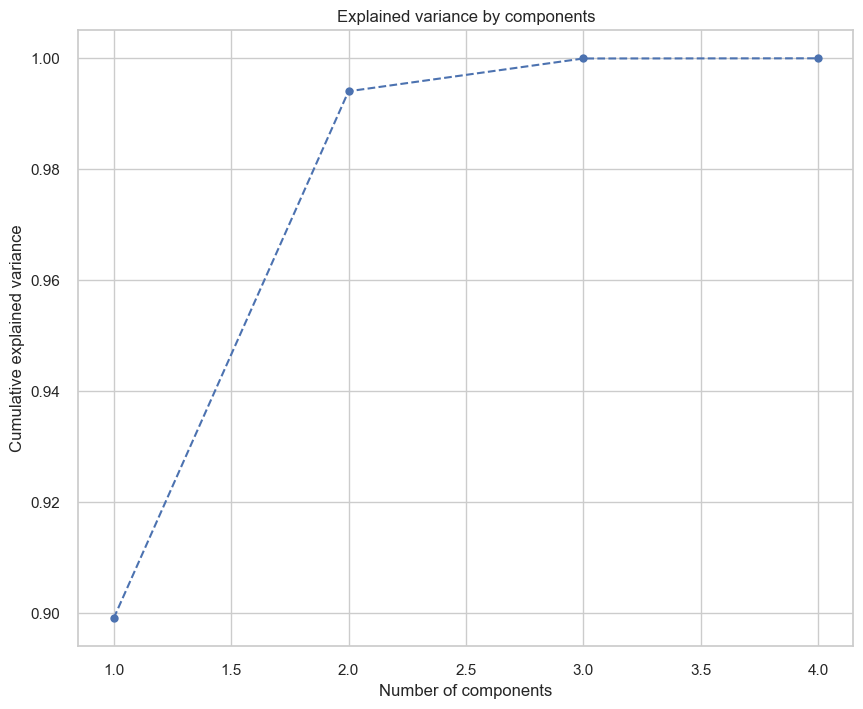

In [356]:
###########
### PCA ###
###########

pca2 = PCA()
pca2.fit(all_data2)
plt.figure(figsize=(10,8))
plt.plot(range(1,len(pca2.explained_variance_ratio_.cumsum())+1), pca2.explained_variance_ratio_.cumsum(),
         marker='o',linestyle='--')
plt.title("Explained variance by components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show();

In [359]:
pca2 = PCA(n_components=2)
pca2.fit(all_data2)
scores_pca2 = pca2.transform(all_data2)

100%|██████████| 39/39 [00:45<00:00,  1.16s/it]


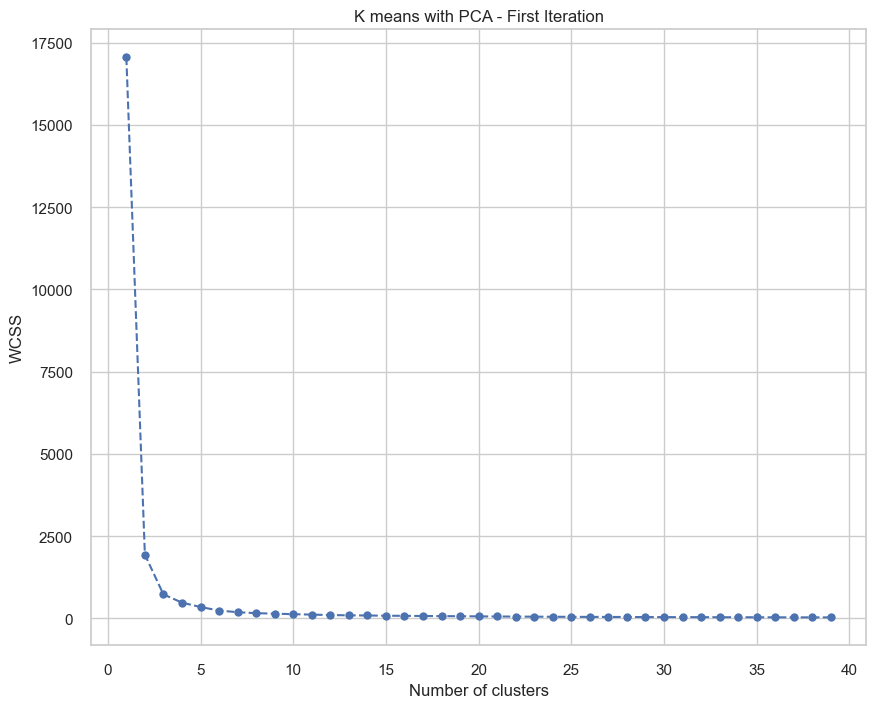

In [358]:
wcss = []
for i in tqdm(range(1,40)):
    kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    kmeans_pca.fit(scores_pca2)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(wcss)+1), wcss,
         marker='o', linestyle='--')
plt.title("K means with PCA - First Iteration")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show();

In [360]:
kmeans_pca2 = KMeans(n_clusters=3, init="k-means++", random_state=42)
kmeans_pca2.fit(scores_pca2)
df_segm_pca_means2 = pd.concat(
    [all_data2.reset_index(drop=True), pd.DataFrame(scores_pca2)], axis=1)
df_segm_pca_means2.columns.values[-2:] = ['Component 1', 'Component 2']

df_segm_pca_means2['Clusters'] = kmeans_pca2.labels_

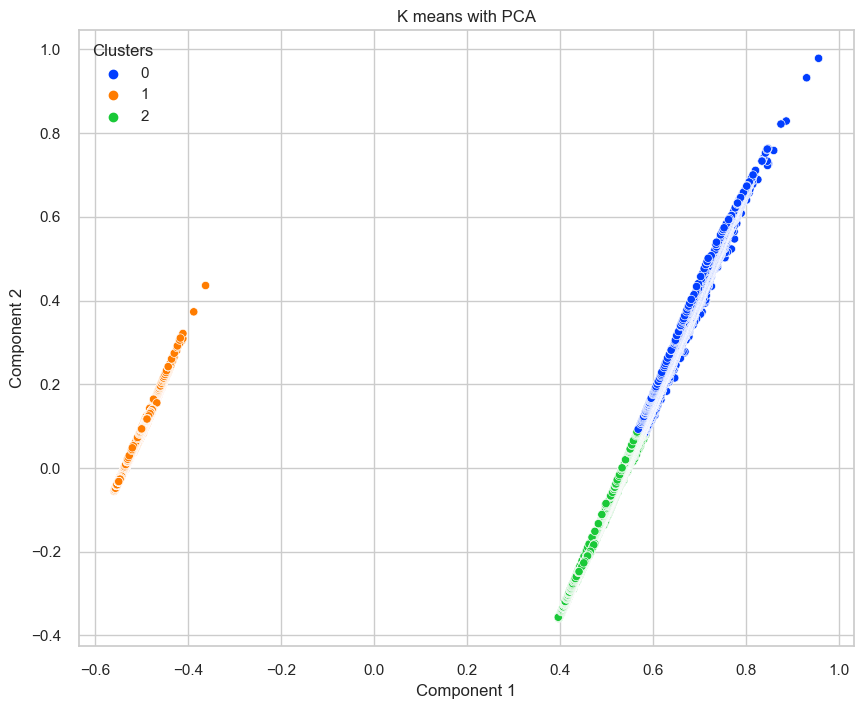

In [361]:
x_axis = df_segm_pca_means2['Component 1']
y_axis = df_segm_pca_means2['Component 2']
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=x_axis, y=y_axis, hue=df_segm_pca_means2['Clusters'], palette="bright")
plt.title("K means with PCA")
plt.show()

#### Important columns

In [362]:
a = list(all_data2.columns)
try:
    a.remove('index')
except:
    a = list(all_data2.columns)

clust_check2 = df_segm_pca_means2.groupby(['Clusters']).mean()
clust_checks2 = clust_check2[a]
print(clust_checks2.shape)
clust_checks2

(3, 4)


,carat,price,size,feature_3
Clusters,,,,
0,0.306140,0.653970,0.315984,0.0
1,0.052687,0.054522,0.056089,1.0
2,0.156995,0.222609,0.162666,0.0


In [363]:
for name in a:

    mean_val = np.mean(clust_checks2[name])
    clust_checks2[str('Index_') + str(name)] = (clust_checks2[name]/mean_val) * 100


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [364]:
import_col2 = []
index_col = [col for col in clust_checks2 if col.startswith('Index')]
for name in index_col:
    if ((min(clust_checks2[name]) < 60) | (max(clust_checks2[name]) > 250)) & (min(clust_checks2[name]) != 0):
        import_col2.append(name)

print(len(import_col2), import_col2)


3 ['Index_carat', 'Index_price', 'Index_size']


In [365]:
clust_checks3 = clust_checks2.sort_values(by='price')
clust_checks3[index_col]

,Index_carat,Index_price,Index_size,Index_feature_3
Clusters,,,,
1,30.642709,17.567039,31.466993,300.0
2,91.307533,71.724456,91.259244,0.0
0,178.049758,210.708505,177.273762,0.0


### Models

#### Gradient Boosting Regressor

In [366]:
gbr = GradientBoostingRegressor(random_state=0)

In [367]:
GradientBoostingRegressor().get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [368]:
gbr_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

gbr_gridsearch = GridSearchCV(gbr, gbr_param_grid, cv = 5, verbose = 2)

gbr_gridsearch.fit(X_train, y_train)

print("Best parameters: ", gbr_gridsearch.best_params_)
# Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
print("Cross Validation Score: ", gbr_gridsearch.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

KeyboardInterrupt: 

In [ ]:
gbr_hyp = GradientBoostingRegressor(random_state=0,
                                    learning_rate = gbr_gridsearch.best_params_['learning_rate'],
                                    n_estimators = gbr_gridsearch.best_params_['n_estimators'],
                                    max_depth = gbr_gridsearch.best_params_['max_depth'],
                                    min_samples_split = gbr_gridsearch.best_params_['min_samples_split'],
                                    min_samples_leaf = gbr_gridsearch.best_params_['min_samples_leaf'])

In [ ]:
gbr_valid_score = gbr_gridsearch.score(X_test, y_test)

print("Validation Score: ", gbr_valid_score)

gbr_hyp.fit(X_train, y_train)

# MAE:  2.230827876694104
# RMSE:  3.1949612716361906

gbr_mae, gbr_rmse, gbr_r2 = diag_vals(gbr_hyp)

#### Adaboost Regressor

In [ ]:
AdaBoostRegressor().get_params().keys()

In [ ]:
abr = AdaBoostRegressor()

abr_param_grid = {
    'learning_rate': [0.4, 0.2, 0.1, 0.05, 0.01],
    'n_estimators': [50, 100, 200, 300, 400],
    'loss' : ['linear', 'square', 'exponential']
}

abr_gridsearch = GridSearchCV(abr, abr_param_grid, cv = 3, verbose = 2)

abr_gridsearch.fit(X_train, y_train)

print("Best parameters: ", abr_gridsearch.best_params_)
# Best parameters:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 50}
# Cross Validation Score:  0.07744818634601136
print("Cross Validation Score: ", abr_gridsearch.best_score_)

In [ ]:
abr_hyp = AdaBoostRegressor(random_state=0,
                            learning_rate = abr_gridsearch.best_params_['learning_rate'],
                            n_estimators = abr_gridsearch.best_params_['n_estimators'],
                            loss = abr_gridsearch.best_params_['loss'])

In [ ]:
abr_valid_score = abr_gridsearch.score(X_test, y_test)

print("Validation Score: ", abr_valid_score)
# Validation Score:  0.1195960678230149

abr_hyp.fit(X_train, y_train)

y_pred_abr = abr_hyp.predict(X_test)

# MAE:  71.79626747527546
# RMSE:  218.55941440071533
# R2 score:  0.1211632427225472

abr_mae, abr_rmse, abr_r2 = diag_vals(y_pred_abr)

#### Light GBM Regressor

In [ ]:
lg.LGBMRegressor().get_params().keys()

In [ ]:
lgb = lg.LGBMRegressor()

lgb_param_grid = {
    'num_leaves' : [60, 100, 200],
    'min_data_in_leaf': [50, 100, 500],
    'max_bin' : [200, 300, 500],
    'learning_rate': [0.2, 0.1, 0.01, 0.001],
    'max_depth': [5, 7, 9],
    'n_estimators': [100, 200, 400]
}

lgb_gridsearch = GridSearchCV(lgb, lgb_param_grid, cv = 5, verbose = 2)

lgb_gridsearch.fit(X_train, y_train)

print("Best parameters: ", lgb_gridsearch.best_params_)

Best parameters:  {'learning_rate': 0.1, 'max_bin': 500, 'max_depth': 7, 'min_data_in_leaf': 100, 'n_estimators': 100, 'num_leaves': 100}
Cross Validation Score:  0.13607427645893372

print("Cross Validation Score: ", lgb_gridsearch.best_score_)

In [ ]:
lgb_hyp = lg.LGBMRegressor(random_state=0,
                            num_leaves = lgb_gridsearch.best_params_['num_leaves'],
                            min_data_in_leaf = lgb_gridsearch.best_params_['min_data_in_leaf'],
                            max_bin = lgb_gridsearch.best_params_['max_bin'],
                            learning_rate = lgb_gridsearch.best_params_['learning_rate'],
                            n_estimators = lgb_gridsearch.best_params_['n_estimators'],
                            max_depth = lgb_gridsearch.best_params_['max_depth'])

In [ ]:
lgb_valid_score = lgb_gridsearch.score(X_test, y_test)

print("Validation Score: ", lgb_valid_score)
# Validation Score:  0.9092250766806657

lgb_hyp.fit(X_train, y_train)

y_pred_lgb = lgb_hyp.predict(X_test)

# MAE:  1.9961167535661593
# RMSE:  2.820238676253174
# R2 score:  0.9092250766806657

lgb_mae, lgb_rmse, lgb_r2 = diag_vals(lgb_hyp)

#### Random Forest Regressor

In [369]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [370]:
rfr = RandomForestRegressor(random_state=0, n_jobs=-1)

rfr_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2']
}

rfr_gridsearch = GridSearchCV(rfr, rfr_param_grid, cv=3, verbose = 2)

rfr_gridsearch.fit(X_train, y_train)

print("Best parameters: ", rfr_gridsearch.best_params_)

# Best parameters:  {'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 200}
# Cross Validation Score:  0.10538253242185136
print("Cross Validation Score: ", rfr_gridsearch.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   3.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total t

[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=   2.2s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=   2.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=   2.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   1.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   1.1s
[CV] END max_depth=5, max_features=auto, min_sample

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_sample

[CV] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.7s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.7s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.7s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, max_features=log2, min_sampl

[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.8s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.8s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.8s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   1.3s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   1.3s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   1.4s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   2.4s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   2.6s
[CV] END max_depth=7, max_features=auto, min_sample

[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.9s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   1.0s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=7, max_features=sqrt, min_sample

[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.5s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   1.0s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.9s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.9s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.3s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.4s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.4s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.6s
[CV] END max_depth=7, max_features=log2, min_sample

[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.9s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   1.4s
[CV] END max_depth=9, max_features=auto, min_sampl

[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   1.0s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   1.0s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   1.6s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   1.6s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   1.8s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200; total time=   3.0s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200; total time=   3.0s
[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200; total time=   3.1s
[CV] END max_depth=9, max_features=sqrt, min_sampl

[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   0.4s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   0.4s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   0.4s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time=   0.7s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time=   0.7s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time=   0.6s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=   1.1s
[CV] END max_depth=9, max_features=sqrt, min_sample

[CV] END max_depth=9, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   1.1s
[CV] END max_depth=9, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   1.0s
[CV] END max_depth=9, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   1.0s
[CV] END max_depth=9, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=9, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=9, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=9, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=9, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=9, max_features=log2, min_sample

In [371]:
rfr_hyp = RandomForestRegressor(random_state=0,
                                max_depth = rfr_gridsearch.best_params_['max_depth'],
                                max_features = rfr_gridsearch.best_params_['max_features'],
                                min_samples_leaf = rfr_gridsearch.best_params_['min_samples_leaf'],
                                min_samples_split = rfr_gridsearch.best_params_['min_samples_split'],
                                n_estimators = rfr_gridsearch.best_params_['n_estimators'])

In [372]:
rfr_valid_score = rfr_gridsearch.score(X_test, y_test)

print("Validation Score: ", rfr_valid_score)
# Validation Score:  0.13891619560381208

rfr_hyp.fit(X_train, y_train)

y_pred_rfr = rfr_hyp.predict(X_test)

# MAE:  72.77285299768388
# RMSE:  216.3406460817012
# R2 score:  0.13891619560381208

rfr_mae, rfr_rmse, rfr_r2 = diag_vals(rfr_hyp)

Validation Score:  0.923007277176622
MAE:  586.3769014068417
RMSE:  1106.3358177561265
R2 score:  0.923007277176622


#### XGB Regressor

In [382]:
xg.XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [383]:
xgb = xg.XGBRegressor(random_state=0, n_jobs=-1)

xgb_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 5, 7],
    'max_bin' : [50, 100, 300],
    'min_child_weight': [3, 5, 7]
}

xgb_gridsearch = GridSearchCV(xgb, xgb_param_grid, cv = 3, verbose = 2)

xgb_gridsearch.fit(X_train, y_train)

print("Best parameters: ", xgb_gridsearch.best_params_)
print("Cross Validation Score: ", xgb_gridsearch.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=200; total time=   1.9s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=200; total time=   1.6s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=200; total time=   1.7s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=300; total time=   2.4s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=300; total time=   2.4s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=300; total time=   2.7s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=400; total time=   3.4s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=400; total time=   3.2s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_

[CV] END learning_rate=0.1, max_bin=50, max_depth=7, min_child_weight=7, n_estimators=200; total time=   4.8s
[CV] END learning_rate=0.1, max_bin=50, max_depth=7, min_child_weight=7, n_estimators=300; total time=   6.4s
[CV] END learning_rate=0.1, max_bin=50, max_depth=7, min_child_weight=7, n_estimators=300; total time=   6.7s
[CV] END learning_rate=0.1, max_bin=50, max_depth=7, min_child_weight=7, n_estimators=300; total time=   6.1s
[CV] END learning_rate=0.1, max_bin=50, max_depth=7, min_child_weight=7, n_estimators=400; total time=   8.4s
[CV] END learning_rate=0.1, max_bin=50, max_depth=7, min_child_weight=7, n_estimators=400; total time=   8.7s
[CV] END learning_rate=0.1, max_bin=50, max_depth=7, min_child_weight=7, n_estimators=400; total time=   9.2s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, min_child_weight=3, n_estimators=200; total time=   2.3s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, min_child_weight=3, n_estimators=200; total time=   1.8s
[CV] END

[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=5, n_estimators=300; total time=   6.1s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=5, n_estimators=300; total time=   6.8s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=5, n_estimators=400; total time=   8.1s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=5, n_estimators=400; total time=   8.5s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=5, n_estimators=400; total time=   8.1s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=7, n_estimators=200; total time=   4.2s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=7, n_estimators=200; total time=   3.9s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=7, n_estimators=200; total time=   4.5s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=7, n_estimators=300; total time=   5.9s
[

[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=3, n_estimators=400; total time=   8.8s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=3, n_estimators=400; total time=   7.6s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=3, n_estimators=400; total time=   8.4s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=5, n_estimators=200; total time=   3.9s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=5, n_estimators=200; total time=   3.9s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=5, n_estimators=200; total time=   4.0s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=5, n_estimators=300; total time=   6.4s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=5, n_estimators=300; total time=   5.8s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=5, n_estimators=300; total time=   6.4s
[

[CV] END learning_rate=0.05, max_bin=50, max_depth=5, min_child_weight=7, n_estimators=400; total time=   5.5s
[CV] END learning_rate=0.05, max_bin=50, max_depth=7, min_child_weight=3, n_estimators=200; total time=   4.0s
[CV] END learning_rate=0.05, max_bin=50, max_depth=7, min_child_weight=3, n_estimators=200; total time=   3.9s
[CV] END learning_rate=0.05, max_bin=50, max_depth=7, min_child_weight=3, n_estimators=200; total time=   4.5s
[CV] END learning_rate=0.05, max_bin=50, max_depth=7, min_child_weight=3, n_estimators=300; total time=   5.9s
[CV] END learning_rate=0.05, max_bin=50, max_depth=7, min_child_weight=3, n_estimators=300; total time=   5.9s
[CV] END learning_rate=0.05, max_bin=50, max_depth=7, min_child_weight=3, n_estimators=300; total time=   6.0s
[CV] END learning_rate=0.05, max_bin=50, max_depth=7, min_child_weight=3, n_estimators=400; total time=   8.6s
[CV] END learning_rate=0.05, max_bin=50, max_depth=7, min_child_weight=3, n_estimators=400; total time=   7.9s
[

[CV] END learning_rate=0.05, max_bin=100, max_depth=5, min_child_weight=7, n_estimators=200; total time=   3.2s
[CV] END learning_rate=0.05, max_bin=100, max_depth=5, min_child_weight=7, n_estimators=200; total time=   3.2s
[CV] END learning_rate=0.05, max_bin=100, max_depth=5, min_child_weight=7, n_estimators=300; total time=   4.2s
[CV] END learning_rate=0.05, max_bin=100, max_depth=5, min_child_weight=7, n_estimators=300; total time=   4.0s
[CV] END learning_rate=0.05, max_bin=100, max_depth=5, min_child_weight=7, n_estimators=300; total time=   4.0s
[CV] END learning_rate=0.05, max_bin=100, max_depth=5, min_child_weight=7, n_estimators=400; total time=   5.4s
[CV] END learning_rate=0.05, max_bin=100, max_depth=5, min_child_weight=7, n_estimators=400; total time=   5.9s
[CV] END learning_rate=0.05, max_bin=100, max_depth=5, min_child_weight=7, n_estimators=400; total time=   5.5s
[CV] END learning_rate=0.05, max_bin=100, max_depth=7, min_child_weight=3, n_estimators=200; total time=

[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=5, n_estimators=300; total time=   4.1s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=5, n_estimators=300; total time=   4.0s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=5, n_estimators=300; total time=   4.1s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=5, n_estimators=400; total time=   5.9s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=5, n_estimators=400; total time=   5.4s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=5, n_estimators=400; total time=   5.4s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=7, n_estimators=200; total time=   2.9s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=7, n_estimators=200; total time=   2.8s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=7, n_estimators=200; total time=

[CV] END learning_rate=0.01, max_bin=50, max_depth=5, min_child_weight=3, n_estimators=300; total time=   4.7s
[CV] END learning_rate=0.01, max_bin=50, max_depth=5, min_child_weight=3, n_estimators=400; total time=   5.9s
[CV] END learning_rate=0.01, max_bin=50, max_depth=5, min_child_weight=3, n_estimators=400; total time=120.0min
[CV] END learning_rate=0.01, max_bin=50, max_depth=5, min_child_weight=3, n_estimators=400; total time=   5.5s
[CV] END learning_rate=0.01, max_bin=50, max_depth=5, min_child_weight=5, n_estimators=200; total time=   2.7s
[CV] END learning_rate=0.01, max_bin=50, max_depth=5, min_child_weight=5, n_estimators=200; total time=   3.6s
[CV] END learning_rate=0.01, max_bin=50, max_depth=5, min_child_weight=5, n_estimators=200; total time=   3.2s
[CV] END learning_rate=0.01, max_bin=50, max_depth=5, min_child_weight=5, n_estimators=300; total time=   4.1s
[CV] END learning_rate=0.01, max_bin=50, max_depth=5, min_child_weight=5, n_estimators=300; total time=   3.9s


[CV] END learning_rate=0.01, max_bin=100, max_depth=3, min_child_weight=7, n_estimators=400; total time=   3.4s
[CV] END learning_rate=0.01, max_bin=100, max_depth=3, min_child_weight=7, n_estimators=400; total time=   3.3s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=3, n_estimators=200; total time=   2.6s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=3, n_estimators=200; total time=   2.6s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=3, n_estimators=200; total time=   2.7s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=3, n_estimators=300; total time=   4.5s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=3, n_estimators=300; total time=   3.9s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=3, n_estimators=300; total time=   4.3s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=3, n_estimators=400; total time=

[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_child_weight=7, n_estimators=200; total time=   2.1s
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_child_weight=7, n_estimators=200; total time=   1.6s
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_child_weight=7, n_estimators=200; total time=   1.7s
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_child_weight=7, n_estimators=300; total time=   2.4s
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_child_weight=7, n_estimators=300; total time=   2.4s
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_child_weight=7, n_estimators=300; total time=   2.9s
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_child_weight=7, n_estimators=400; total time=   3.2s
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_child_weight=7, n_estimators=400; total time=   3.2s
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_child_weight=7, n_estimators=400; total time=

In [384]:
xgb_hyp = xg.XGBRegressor(random_state=0,
                          max_depth = xgb_gridsearch.best_params_['max_depth'],
                          learning_rate = xgb_gridsearch.best_params_['learning_rate'],
                          max_bin = xgb_gridsearch.best_params_['max_bin'],
                          min_child_weight = xgb_gridsearch.best_params_['min_child_weight'],
                          n_estimators = xgb_gridsearch.best_params_['n_estimators'])

In [385]:
xgb_valid_score = xgb_gridsearch.score(X_test, y_test)

print("Validation Score: ", xgb_valid_score)

xgb_hyp.fit(X_train, y_train)

xgb_mae, xgb_rmse, xgb_r2 = diag_vals(xgb_hyp)

Validation Score:  0.9401569542213111
MAE:  535.7183703607839
RMSE:  975.3690672884643
R2 score:  0.9401569542213111


#### Neural network

In [ ]:
n_inputs = X_train.shape[1]

nn_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

In [ ]:
nn_model.compile(Adam(learning_rate = 0.0001), loss = 'mse')

In [ ]:
history = nn_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=100, shuffle=True, verbose=2, validation_data=(X_test, y_test))

Epoch 1/100
1564/1564 - 4s - loss: 65586.7422 - val_loss: 51378.1641 - 4s/epoch - 3ms/step
Epoch 2/100
1564/1564 - 3s - loss: 53900.4102 - val_loss: 48558.5664 - 3s/epoch - 2ms/step
Epoch 3/100
1564/1564 - 4s - loss: 52670.2188 - val_loss: 48066.2422 - 4s/epoch - 2ms/step
Epoch 4/100
1564/1564 - 4s - loss: 52372.6055 - val_loss: 47911.3945 - 4s/epoch - 2ms/step
Epoch 5/100
1564/1564 - 3s - loss: 52230.0586 - val_loss: 47858.2891 - 3s/epoch - 2ms/step
Epoch 6/100
1564/1564 - 3s - loss: 52116.7578 - val_loss: 47527.1172 - 3s/epoch - 2ms/step
Epoch 7/100
1564/1564 - 3s - loss: 52029.7109 - val_loss: 47744.9844 - 3s/epoch - 2ms/step
Epoch 8/100
1564/1564 - 4s - loss: 51974.0312 - val_loss: 47522.9922 - 4s/epoch - 2ms/step
Epoch 9/100
1564/1564 - 5s - loss: 51897.9922 - val_loss: 47470.2500 - 5s/epoch - 3ms/step
Epoch 10/100
1564/1564 - 2s - loss: 51823.4648 - val_loss: 47401.8633 - 2s/epoch - 1ms/step
Epoch 11/100
1564/1564 - 2s - loss: 51788.1484 - val_loss: 47424.3906 - 2s/epoch - 1ms/st

In [ ]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

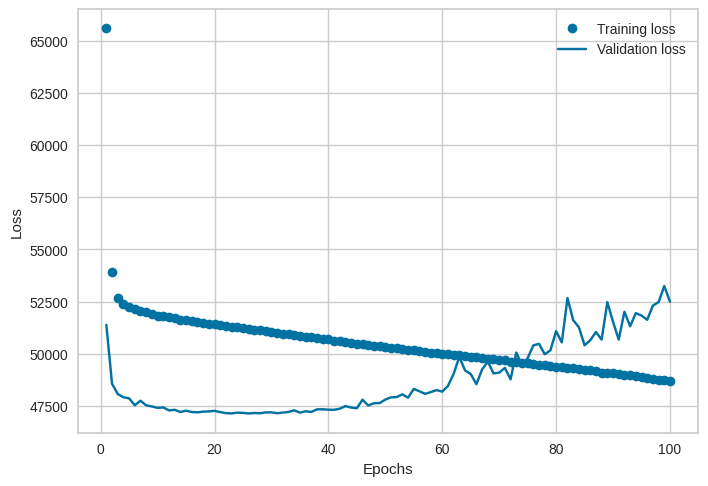

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_nn = nn_model.predict(X_test, batch_size=200, verbose=0)

In [ ]:
nn_mae, nn_rmse, nn_r2 = diag_vals(nn_model)

MAE:  89.2816479437915
RMSE:  229.11007027758296
R2 score:  0.03426597402324272


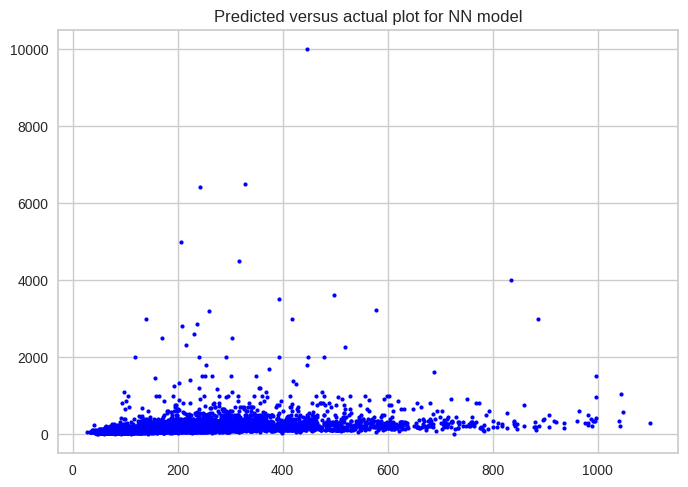

In [ ]:
plt.plot(y_pred_nn, y_test, 'o', color='blue', markersize=3)
plt.title('Predicted versus actual plot for NN model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();

In [ ]:
n_inputs = X_train.shape[1]

nn_model_tanh = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(15, activation='tanh'),
    Dense(10, activation='tanh'),
    Dense(1)
])

In [ ]:
nn_model_tanh.compile(optimizer="adam", loss="mse")

trained_model_tanh = nn_model_tanh.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=100, shuffle=True, verbose=2, validation_data=(X_test, y_test))

y_pred_tanh = nn_model_tanh.predict(X_test)

Epoch 1/200
2443/2443 [==============================] - 6s 2ms/step - loss: 77100.6094
Epoch 2/200
2443/2443 [==============================] - 4s 2ms/step - loss: 71268.9531
Epoch 3/200
2443/2443 [==============================] - 3s 1ms/step - loss: 66813.5547
Epoch 4/200
2443/2443 [==============================] - 3s 1ms/step - loss: 63499.1680
Epoch 5/200
2443/2443 [==============================] - 3s 1ms/step - loss: 61226.1523
Epoch 6/200
2443/2443 [==============================] - 4s 2ms/step - loss: 59818.3672
Epoch 7/200
2443/2443 [==============================] - 3s 1ms/step - loss: 59023.3555
Epoch 8/200
2443/2443 [==============================] - 3s 1ms/step - loss: 58636.7422
Epoch 9/200
2443/2443 [==============================] - 4s 2ms/step - loss: 58455.8125
Epoch 10/200
2443/2443 [==============================] - 4s 2ms/step - loss: 58379.6602
Epoch 11/200
2443/2443 [==============================] - 3s 1ms/step - loss: 58348.5391
Epoch 12/200
2443/2443 [======

In [ ]:
nn_mae_tanh, nn_rmse_tanh, nn_r2_tanh = diag_vals(nn_model_tanh)

MAE:  92.49684365466771
RMSE:  233.1397974497659
R2 score:  -4.61867950085626e-06


#### Hyperparameter model

In [53]:
input_shape = (X_train.shape[1],)
hypermodel = RegressionHyperModel(input_shape)

In [54]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2,
            overwrite=True,
            directory="my_dir",
            project_name="helloworld",)

In [55]:
tuner_rs.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

Trial 10 Complete [00h 01m 11s]
mse: 55207.32421875

Best mse So Far: 49757.27734375
Total elapsed time: 00h 09m 46s


In [56]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
loss, mse = best_model.evaluate(X_test, y_test)

306/306 [==============================] - 1s 2ms/step - loss: 51475.7578 - mse: 51475.7578


In [57]:
print(loss, mse)

51475.7578125 51475.7578125


In [58]:
nn_mae_hyp, nn_rmse_hyp, nn_r2_hyp = diag_vals(best_model)

306/306 [==============================] - 0s 1ms/step
MAE:  103.2128514329877
RMSE:  226.8826667262456
R2 score:  0.05295238986628237


#### Bayesian optimisation

In [60]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            overwrite=True,
            directory="my_dir",
            project_name="helloworld",
        )
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

best_model_bo = tuner_bo.get_best_models(num_models=1)[0]
best_model_bo.evaluate(X_test, y_test)

Trial 10 Complete [00h 01m 24s]
mse: 49963.357421875

Best mse So Far: 49527.69140625
Total elapsed time: 00h 17m 11s
306/306 [==============================] - 1s 1ms/step - loss: 65508.4219 - mse: 65508.4219


[65508.421875, 65508.421875]

In [61]:
nn_mae_bo, nn_rmse_bo, nn_r2_bo = diag_vals(best_model_bo)

306/306 [==============================] - 0s 1ms/step
MAE:  156.11976404814783
RMSE:  255.94610416390594
R2 score:  0.05295238986628237


#### Hyperband

In [2]:
tuner_hb = Hyperband(
            hypermodel,
            max_epochs=5,
            objective='mse',
            seed=42,
            executions_per_trial=2,
            overwrite=True,
            directory="my_dir",
            project_name="helloworld",
        )
tuner_hb.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
best_model_hb = tuner_hb.get_best_models(num_models=1)[0]
best_model_hb.evaluate(X_test, y_test)

NameError: ignored

In [3]:
nn_mae_hb, nn_rmse_hb, nn_r2_hb = diag_vals(best_model_hb)

NameError: ignored

### Residuals

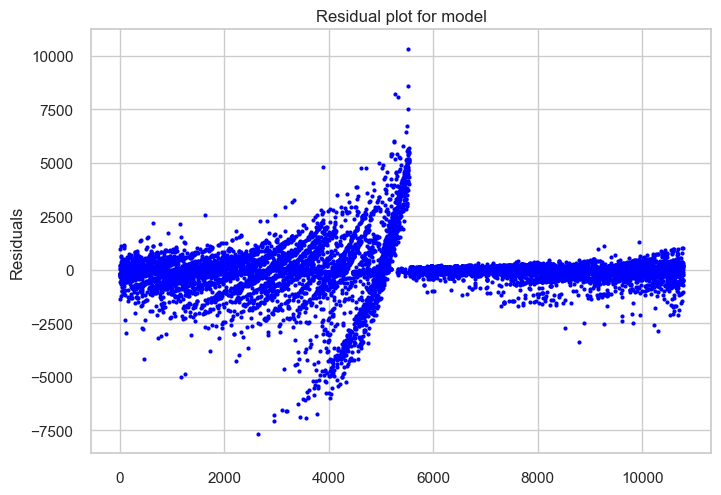

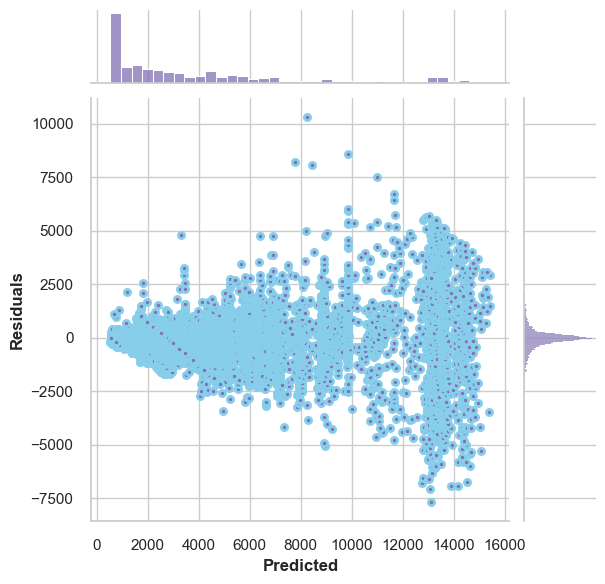

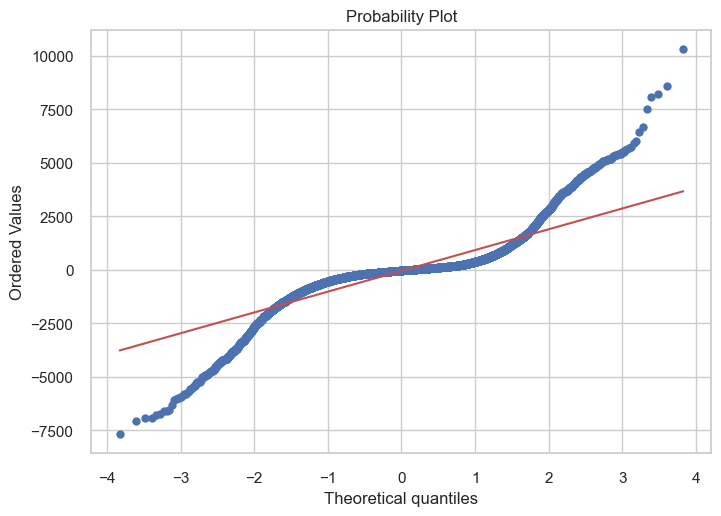

In [375]:
resid_vals(y_pred_rfr)

### Results table

In [ ]:
mae_lst = [nn_mae_hb, nn_mae_bo, nn_mae_hyp, nn_mae_tanh, nn_mae, gbr_mae, abr_mae, lgb_mae, rfr_mae, xgb_mae]
rmse_lst = [nn_rmse_hb, nn_rmse_bo, nn_rmse_hyp, nn_rmse_tanh, nn_rmse, gbr_rmse, abr_rmse, lgb_rmse, rfr_rmse, xgb_rmse]
r2_lst = [nn_r2_hb, nn_r2_bo, nn_r2_hyp, nn_r2_tanh, nn_r2, gbr_r2, abr_r2, lgb_r2, rfr_r2, xgb_r2]
mod_lst = ['Hyperband model', 'Bayesian optimised model', 'Random search model', 'Tanh model', 'Baseline NN model', 'Gradient Boosting Regressor',
           'Adaboost Regressor', 'Light GBM Regressor', 'Random Forest Regressor', 'XGB Regressor']

res_df = pd.DataFrame(mod_lst, columns = ['Model'])
res_df['MAE'] = mae_lst
res_df['RMSE'] = rmse_lst
res_df['R2'] = r2_lst

### Shapley values

In [ ]:
xgb_gridsearch.fit(X_train, y_train);

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb_gridsearch)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.initjs()


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=200; total time=   1.7s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=200; total time=   2.2s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=200; total time=   2.0s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=300; total time=   3.6s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=300; total time=   3.3s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=300; total time=   2.9s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=400; total time=   3.3s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=400; total time=   3.3s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_

[CV] END learning_rate=0.1, max_bin=50, max_depth=7, min_child_weight=7, n_estimators=200; total time=   5.2s
[CV] END learning_rate=0.1, max_bin=50, max_depth=7, min_child_weight=7, n_estimators=300; total time=   5.9s
[CV] END learning_rate=0.1, max_bin=50, max_depth=7, min_child_weight=7, n_estimators=300; total time=   6.0s
[CV] END learning_rate=0.1, max_bin=50, max_depth=7, min_child_weight=7, n_estimators=300; total time=   6.0s


In [380]:
shap_values = shap.TreeExplainer(rfr_gridsearch).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.model_selection._search.GridSearchCV'>

In [381]:
shap.summary_plot(shap_values, X_train)

NameError: name 'shap_values' is not defined

In [ ]:
shap.plots.violin(shap_values)

In [ ]:
shap.plots.violin(shap_values, plot_type="layered_violin")

In [ ]:
shap.plots.heatmap(shap_values)

In [ ]:
order = np.argsort(y_pred)
shap.plots.heatmap(shap_values, instance_order=order)

In [ ]:
order = np.argsort(data['shell weight'])
shap.plots.heatmap(shap_values, instance_order=order)